# Missteering measurement

Measuring the vertical missteering at C171. Quick measurements seems to show that in this case the analytical law is respected (see PSMD logbook on May 16th).

The calibration for DVT50 from current to angle can be derived by:
```
Finding the current boundaries for DVT50 using YASP:
-200 urad = -3.25 A
-100 urad = -2.44 A
0 urad = -1.63 A
+100 urad = -0.82 A
+200 urad = -0.01 A 
```

**SECOND ATTEMPT TO MEASURE AFTER 16 MAY** --> there the V wirescanner was triggered at C181 for a mistake

In [1]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

from scipy.optimize import curve_fit

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/PS-injection-steering/Data analysis/2018.06.06
Your IP is 172.17.0.6
2018-07-16 09:24:46
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [2]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [3]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'logical_PI_KFA45.K.value', # Kicker k parameter value (mrad)
                'PI_KFA45.AQN1.value',
                'PI_KFA45.CCV.value', 
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BPM.AcquisitionTrajectoryBBB.value.channelNames',
                'PR_BCT_ST.Samples.value.samples']



In [4]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data/2018*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 110 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/data/2018.06.06.20.45.06.933.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/data/2018.06.06.21.52.41.406.mat


In [5]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

# Data cleanup

In [6]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
# myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:59:28.300000'].name) # non-phys emittance

No duplicates found
---
BPM data ok
---


# Load the DVT50 current settings 
Different files because comes from the PSB monitor

In [7]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/data_PSB/'

matlabVars = ['AQN.current', # DVT50
                'CCV.current']

# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/PSB2018*.mat'))[:-1]
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

AQN_DVT50 = np.empty(len(files),dtype=float)
CCV_DVT50 = np.empty(len(files),dtype=float)

for k in range(len(files)):
    AQN_DVT50[k] = scipy.io.loadmat(files[k])['AQN'][0][0][0][0][0]
    CCV_DVT50[k] = scipy.io.loadmat(files[k])['CCV'][0][0][0][0][0]

Found 110 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/data_PSB/PSB2018.06.06.20.44.44.558.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/data_PSB/PSB2018.06.06.21.52.04.292.mat


In [8]:
myDataFrame['AQN_DVT50'] = AQN_DVT50
myDataFrame['CCV_DVT50'] = CCV_DVT50

# Import the optics model

In [5]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/PS-injection-steering/MADx/PS_twiss_files/ps_6.21_6.185.twiss')

Problem parsing: @ ORBIT_-CT        %le                  -0

Going to be parsed as string
Problem persits, let's ignore it!


# Booster emittance

In [10]:
# emix_norm_PSB = 2.484
# emiy_norm_PSB = 2.076

# emix_geom_PSB = emix_norm_PSB/(betar*gammar)
# emiy_geom_PSB = emiy_norm_PSB/(betar*gammar)

# Match the tomogram data

In [11]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt(fileName[0:-4] + '/d001.data')
    image=np.loadtxt(fileName[0:-4] + '/image001.data')
    with open(fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2]),
            'cycleStamp':np.int(tomofileheader[1]),                    # cyclestamp in unix time
            'pickupSensitivity':np.double(tomofileheader[97])          # pickup sensitivity
    }

    with open(fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [12]:
# new tomogram analysis
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06/'
files_tomo=sorted(glob.glob(folderPath+'/tomo_data/*.dat'))

tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_001.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_002.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_003.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_004.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_005.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_006.dat
/eos/project/l/liu/Instrumen

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_052.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_053.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_054.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_055.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_056.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_057.dat
/eos/project/l/liu/Instrumen

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_103.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_104.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_105.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_106.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_107.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_108.dat
/eos/project/l/liu/Instrumen

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_154.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_155.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_156.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_157.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_158.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2018.06.06//tomo_data/injall_159.dat
/eos/project/l/liu/Instrumen

In [13]:
timeTolerance = 15

# ---------- Vars initialisation
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['tomoFilename']=np.str
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
myDataFrame['beta']=np.nan
myDataFrame['gamma']=np.nan
myDataFrame['deltaP_P']=[np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['momentumProfile']=[np.empty(0,dtype=float)]*len(myDataFrame)


succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]
    tomo_dpprms = tomo_data['deltaP_P_RMS'].iloc[k]
#     tomo_pkldens = tomo_data['peakLineDensity'].iloc[k]
    betar = tomo_data['beta'].iloc[k]
    gammar = tomo_data['gamma'].iloc[k]
    dpp_profil = tomo_data['deltaP_P'].iloc[k]
    p_profil = tomo_data['myProfile'].iloc[k]    


    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x]= tomo_dpprms
#             myDataFrame['peakLineDensity'].iloc[x]= tomo_pkldens
            myDataFrame['beta'].iloc[x]= betar
            myDataFrame['gamma'].iloc[x]= gammar
            myDataFrame['deltaP_P'].iloc[x]= dpp_profil
            myDataFrame['momentumProfile'].iloc[x]= p_profil


            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


109/188 are within the timeTolerance
length of dataframe is: 110


In [14]:
# discard the elements without tomogram
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

# Save the imported data

In [15]:
myDataFrame.to_pickle('imported_data_2018.06.06.pkl')

In [6]:
# myDataFrame=pnd.read_pickle('imported_data_2018.06.06.pkl')

# Intensity

In [7]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][100]/np.max(x) )

Text(0,0.5,u'Peak intensity (10^10 ppb)')

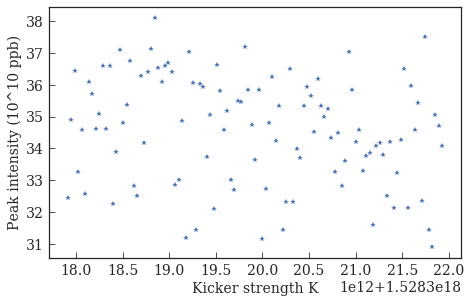

In [8]:
plt.plot(myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')

Text(0,0.5,u'Losses')

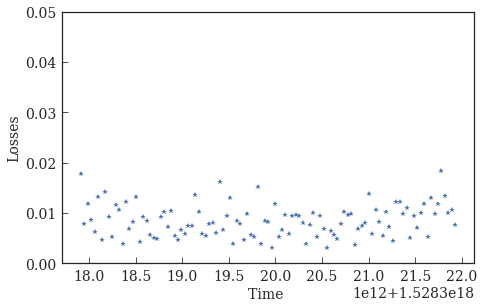

In [9]:
plt.plot(myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,0.05))
plt.xlabel('Time ')
plt.ylabel('Losses')

Text(0.5,1,u'10 shots intensity')

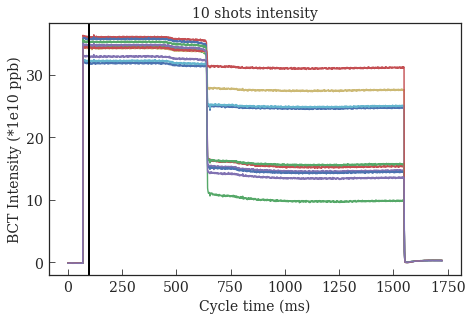

In [10]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=100, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# Calculate wire scanner emittance
## X plane
### Traditional method

In [11]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])


/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [12]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

### Dispersive profile deconvolution

In [13]:
# BWS65
betax = 21.77988929
Dx = 3.24577470

betax = 20.11
Dx = 3.2

def deconv_caller(row):
    return myToolbox.computeTransverseEmittance(row['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'],
                              row['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'],
                              row['momentumProfile'],
                              row['deltaP_P'],
                              row['beta']*row['gamma'],
                              betaOptical_m=betax,Dispersion_m=Dx)

myDataFrame['Deconvolution_result'] = myDataFrame.apply(deconv_caller,axis=1)



for k in myDataFrame.index:  
    myDataFrame.loc[k,'Emittance_x_deconv'] = myDataFrame.loc[k,('Deconvolution_result')]['emittance_um']


## Y plane

In [14]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [15]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

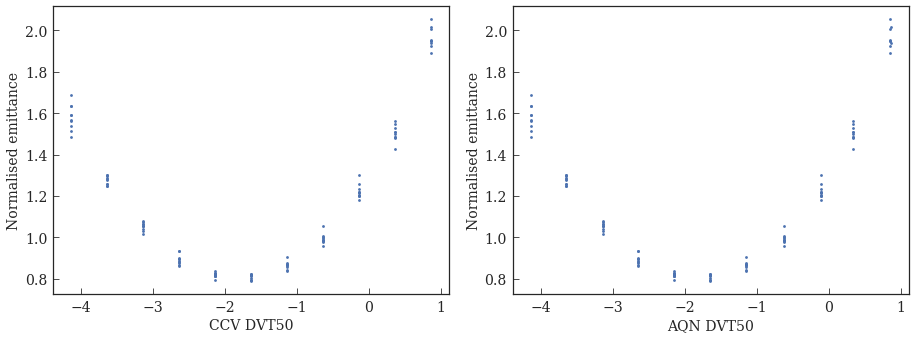

In [16]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

ax[0].plot(myDataFrame['CCV_DVT50'], myDataFrame['WS_emittance_y'],'.' )
ax[0].set_xlabel('CCV DVT50')
ax[0].set_ylabel('Normalised emittance')

ax[1].plot(myDataFrame['AQN_DVT50'], myDataFrame['WS_emittance_y'],'.' )
ax[1].set_xlabel('AQN DVT50')
ax[1].set_ylabel('Normalised emittance')

fig.tight_layout()

## Find a calibration curve for current --> angle of DVT50

In [17]:
# This time simpler, no reyasping happened
#data from YASP
angle = np.array([-0.2e-3,-0.1e-3,0.,0.1e-3,0.2e-3],dtype=float) 
current = np.array([-3.25,-2.44,-1.63,-0.82,-0.01],dtype=float)

#interpolation
params = np.polyfit(current,angle,1)
def interp_func(x):
    return params[0]*x + params[1]


In [18]:
myDataFrame['DVT50_kick'] = interp_func(myDataFrame['AQN_DVT50'])

Text(0,0.5,u'Normalised emittance (um)')

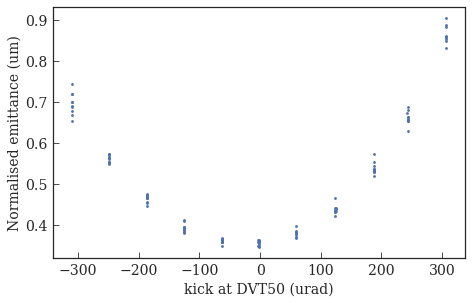

In [19]:
# so now in kick units
fig, ax = plt.subplots(1)

ax.plot(1e6*myDataFrame['DVT50_kick'], myDataFrame['WS_geom_emittance_y'],'.' )
ax.set_xlabel('kick at DVT50 (urad)')
ax.set_ylabel('Normalised emittance (um)')

## Calculate average emittance per measurement point

In [20]:
# find indexes of the shots at the same kick
ks = []
ks_idx = []
for k in range(len(myDataFrame)):
    if k == 0 :
        prevk = myDataFrame['DVT50_kick'].iloc[k]
        ks.append(prevk)
        ks_idx.append(k)
        continue
#     print(k)
    
    thisk = myDataFrame['DVT50_kick'].iloc[k]
    if (prevk-thisk) != 0:
#         print(thisk)
        ks.append(thisk)
        ks_idx.append(k)
    prevk = thisk

In [21]:
# manual adjusting
ks_idx = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [22]:
k_values = np.array((myDataFrame['DVT50_kick'].iloc[ks_idx]))

emix_mean = np.empty(len(ks_idx),dtype=float)
emiy_mean = np.empty(len(ks_idx),dtype=float)
emix_std = np.empty(len(ks_idx),dtype=float)
emiy_std = np.empty(len(ks_idx),dtype=float)


for k in range(len(ks_idx)):
    if k==len(ks_idx)-1:
        emix_mean[k] = np.mean(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emiy_mean[k] = np.mean(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emix_std[k] = np.std(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:]) # the last tranche to close the array
        emiy_std[k] = np.std(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:]) # the last tranche to close the array
    else:
        emix_mean[k] = np.mean(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emiy_mean[k] = np.mean(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emix_std[k] = np.std(myDataFrame['WS_geom_emittance_x'].iloc[ks_idx[k]:ks_idx[k+1]]) 
        emiy_std[k] = np.std(myDataFrame['WS_geom_emittance_y'].iloc[ks_idx[k]:ks_idx[k+1]])



In [23]:
k_values

array([ -3.10078741e-04,  -2.48576402e-04,  -1.86471129e-04,
        -1.24968849e-04,  -6.34665101e-05,  -3.17015707e-06,
         5.95380795e-05,   1.24055221e-04,   1.88572328e-04,
         2.43442037e-04,   3.07356193e-04])

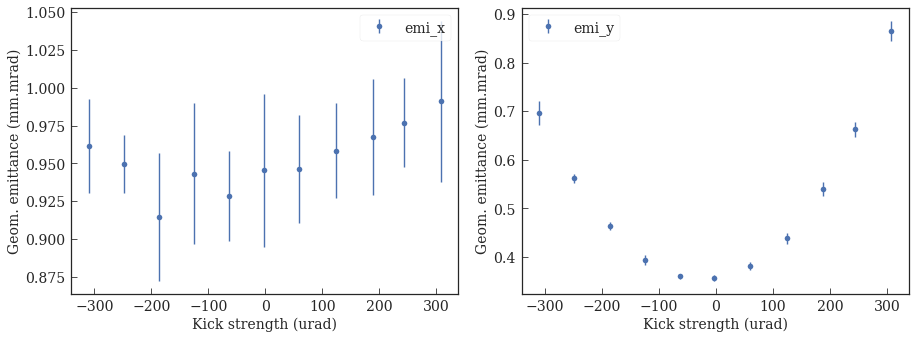

In [24]:
fig, ax = plt.subplots(1,2,figsize=(13,5))

ax[0].errorbar(1e6*k_values, emix_mean, yerr=emix_std, fmt='o',label='emi_x')
ax[0].set_xlabel('Kick strength (urad)')
ax[0].set_ylabel('Geom. emittance (mm.mrad)')
ax[0].legend(frameon=True)

ax[1].errorbar(1e6*k_values, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y')
ax[1].set_xlabel('Kick strength (urad)')
ax[1].set_ylabel('Geom. emittance (mm.mrad)')
ax[1].legend(frameon=True)

fig.tight_layout()

fig.savefig('Vert_steering_emi_xy.eps', format='eps',dpi=100)

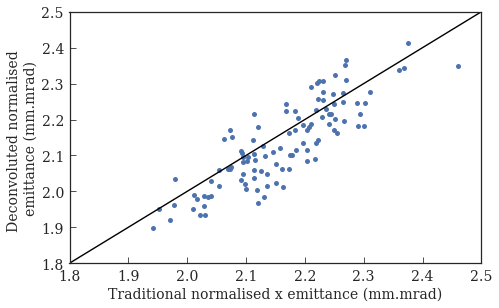

In [25]:
fig2, ax2 = plt.subplots(1)
ax2.plot(myDataFrame['WS_emittance_x'],myDataFrame['Emittance_x_deconv'],'.',markersize=10)
plt.xlabel('Traditional normalised x emittance (mm.mrad)')
plt.ylabel('Deconvoluted normalised \nemittance (mm.mrad)')

ax2.plot([.5,10.],[.5,10.],'-k')
x1,x2,y1,y2 = plt.axis()
plt.axis((1.8,2.5,1.8,2.5))

fig2.savefig('BCMS_under_coupling_Wemi_vs_deconv.eps', format='eps')

Model function: a(x - b)^2 + c
Fit params:
 a= 4.31611878034+/-0.0915097534708
 b= -2.61242572161e-05+/-1.93042691406e-06
 c= 3.52237258608e-07+/-2.62838867376e-09


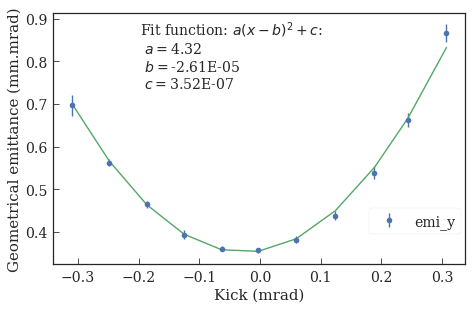

In [26]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = k_values
ydata = 1e-6*emiy_mean

fig, ax = plt.subplots(1)
ax.errorbar(1e3*k_values, emiy_mean, yerr=emiy_std, fmt='o',label='emi_y')

p, cov = curve_fit(f_to_fit,xdata,ydata,sigma=emiy_std)
err = np.sqrt(np.diag(cov))
# xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xdata, 1e6*f_to_fit(xdata,*p))


#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params:\n a= ' + str(p[0]) + '+/-' + str(err[0]) + '\n b= ' + str(p[1]) + '+/-' + str(err[1]) + '\n c= '+ str(p[2]) + '+/-' + str(err[2])


plt.xlabel('Kick (mrad)',fontsize=15)
plt.ylabel('Geometrical emittance (mm.mrad)',fontsize=15)

ax.text(0.21, 0.98, 'Fit function: $a(x-b)^2+c$:\n $a=$%.2f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0.7,2.3))
plt.legend(frameon=True,bbox_to_anchor=(0.75,.25))

fig.savefig('emi_xy_fitC171.eps', format='eps',dpi=100)

# BPMs

In [27]:
# BPMs
myDataFrame['BPMx'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,:])
myDataFrame['BPMy'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,:])


#legacy from now on
#add field for the first two turns and splitting x and y pickups, and turn to mm 
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,1])
myDataFrame['BPMx_turn3'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[0:43,2])
myDataFrame['BPMy_turn3'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[-43:,2])
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: 0.1*x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: 0.1*x[-43:,1])

# BPMS in order to compute the angles
def turnsForAngle(turn1, turn2, turn3):
    '''
    Put in row the BPM data as the beam sees them, so from BPM45 on.
    2 turns + 1st BPM of turn 3
    '''
    turn0 = turn1[18:]
    turn1 = np.concatenate((turn1[:18],turn2[18:]))
    turn2 = np.concatenate((turn2[:18],np.array([turn3[18]])))
    return np.concatenate((turn0,turn1,turn2))
    
myDataFrame['BPMx_2turns'] = [np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['BPMy_2turns'] = [np.empty(0,dtype=float)]*len(myDataFrame)
for k in myDataFrame.index:
    myDataFrame['BPMx_2turns'].loc[k] = turnsForAngle(myDataFrame['BPMx_turn1'].loc[k], myDataFrame['BPMx_turn2'].loc[k], myDataFrame['BPMx_turn3'].loc[k])# first two turns + first BPM of turn 3, starting from BPM45
    myDataFrame['BPMy_2turns'].loc[k] = turnsForAngle(myDataFrame['BPMy_turn1'].loc[k], myDataFrame['BPMy_turn2'].loc[k], myDataFrame['BPMy_turn3'].loc[k])# first two turns + first BPM of turn 3, starting from BPM45
    # set BPM43 to NaN  --> Just in X
    myDataFrame['BPMx_2turns'].loc[k][42] = np.NaN
    myDataFrame['BPMx_2turns'].loc[k][-2] = np.NaN
#     myDataFrame['BPMy_2turns'].loc[k][42] = np.NaN
#     myDataFrame['BPMy_2turns'].loc[k][-2] = np.NaN

In [28]:
# get the twiss at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_betax = []
BPM_alphax = []
BPM_betay = []
BPM_alphay = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_betax.append(optics.BETA11[k])   
        BPM_alphax.append(optics.ALFA11[k])
        BPM_betay.append(optics.BETA22[k])   
        BPM_alphay.append(optics.ALFA22[k])

# for some reason the last bpm is the 00, place it back at the beginning
BPM_name = [BPM_name[-1]] + BPM_name[:-1]
BPM_idx = [BPM_idx[-1]] + BPM_idx[:-1]
BPM_betax = [BPM_betax[-1]] + BPM_betax[:-1]
BPM_alphax = [BPM_alphax[-1]] + BPM_alphax[:-1]
BPM_betay = [BPM_betay[-1]] + BPM_betay[:-1]
BPM_alphay = [BPM_alphay[-1]] + BPM_alphay[:-1]

# casting stuff
BPM_betax = np.array(BPM_betax)
BPM_alphax = np.array(BPM_alphax)
BPM_betay = np.array(BPM_betay)
BPM_alphay = np.array(BPM_alphay)

## Get the transfer matrix between the BPMs

So for example for BPM00 and BPM03

$$
\begin{pmatrix}
  x  \\
  x^\prime
 \end{pmatrix}_\text{BPM00}
=
\begin{pmatrix}
  a & b \\
  c & d
 \end{pmatrix}
\begin{pmatrix}
  x  \\
  x^\prime
 \end{pmatrix}_\text{BPM03}
$$

so the angle at the first BPM can be obtained just from the position at the two, if the optics model is known
$$
x^\prime_\text{BPM00} = c x_\text{BPM00} + \frac{d}{b} (x_\text{BPM03} - a x_\text{BPM00})
$$


In [29]:
# load transfer matrixes
X_TM = [] # --> X_TM[0] is the matrix between BPM03 and BPM00
Y_TM = []

for k in range(43):
    fname = 'sector'+str(k)+'.sec'
    imported_twiss = metaclass.twiss('/eos/user/e/esenes/PS-injection-steering/MADx/transfer_matrix_BPMs/6.21-6.185/'+fname)

    x_transfer_matrix = np.matrix([[imported_twiss.R11[-1], imported_twiss.R12[-1]],[imported_twiss.R21[-1], imported_twiss.R22[-1]]],dtype=float)
    y_transfer_matrix = np.matrix([[imported_twiss.R33[-1],imported_twiss.R34[-1]],[imported_twiss.R43[-1],imported_twiss.R44[-1]]],dtype=float)

    X_TM.append(x_transfer_matrix)
    Y_TM.append(y_transfer_matrix)

print('Done.')

Done.


In [30]:
def getAngle(transfer_matrix, thisBPM, nextBPM):
    a = transfer_matrix[0,0]
    b = transfer_matrix[0,1]
    c = transfer_matrix[1,0]
    d = transfer_matrix[1,1]
    return (c*thisBPM) + ((d/b)*(nextBPM - (a*thisBPM)))

# Get the angles

In [31]:
turnNumber = 5000
BPM_n = 43

nanMatrix = np.empty((int(BPM_n),int(turnNumber)),dtype=float); nanMatrix[:]=np.nan
myDataFrame['BPMx_angle'] = [nanMatrix]*len(myDataFrame)
myDataFrame['BPMy_angle'] = [nanMatrix]*len(myDataFrame)

for name in myDataFrame.index:
    # init
    nanMatrixX = np.empty((int(BPM_n),int(turnNumber)),dtype=float); nanMatrixX[:]=np.nan
    nanMatrixY = np.empty((int(BPM_n),int(turnNumber)),dtype=float); nanMatrixY[:]=np.nan

    for k in range(BPM_n-1):
        # X BPMs
        thisBPM = myDataFrame['BPMx'].loc[name][k,:]
        nextBPM = myDataFrame['BPMx'].loc[name][k+1,:]

        nanMatrixX[k, :] = getAngle(X_TM[k], thisBPM, nextBPM) 

        # Y BPMs
        thisBPM = myDataFrame['BPMy'].loc[name][k,:]
        nextBPM = myDataFrame['BPMy'].loc[name][k+1,:]

        nanMatrixY[k, :] = getAngle(Y_TM[k], thisBPM, nextBPM) 
    #last BPM
    k = BPM_n-1

    thisBPM = myDataFrame['BPMx'].loc[name][k,:]
    nextBPM = myDataFrame['BPMx'].loc[name][0,:]
    nanMatrixX[k, :] = getAngle(X_TM[k], thisBPM, nextBPM) 

    thisBPM = myDataFrame['BPMy'].loc[name][k,:]
    nextBPM = myDataFrame['BPMy'].loc[name][0,:]
    nanMatrixY[k, :] = getAngle(Y_TM[k], thisBPM, nextBPM) 

    #store data
    myDataFrame['BPMx_angle'].loc[name] = nanMatrixX
    myDataFrame['BPMy_angle'].loc[name] = nanMatrixY

    
    

## Get the angles for the first two turns

In [32]:
# prepare the storage
myDataFrame['BPMy_2turns_angles'] = [np.empty(0,dtype=float)]*len(myDataFrame)

for j in myDataFrame.index:

    bpmData = myDataFrame['BPMy_2turns'].loc[j]
    angles = []

    for k in range(len(bpmData)-1):

        idx_tm = np.mod(k, len(Y_TM))    
        transfer_matrix = Y_TM[idx_tm]

        if k < len(bpmData)-1:
            angles.append(getAngle(transfer_matrix, bpmData[k], bpmData[k+1]))

    # casting and add a NaN to match the length
    angles.append(np.NaN)
    angles = np.array(angles,dtype=float)

    # put it in the dataframe
    myDataFrame['BPMy_2turns_angles'].loc[j] = angles

In [33]:
# prepare the storage
myDataFrame['BPMx_2turns_angles'] = [np.empty(0,dtype=float)]*len(myDataFrame)

for j in myDataFrame.index:

    bpmData = myDataFrame['BPMx_2turns'].loc[j]
    angles = []

    for k in range(len(bpmData)-1):

        idx_tm = np.mod(k, len(X_TM))    
        transfer_matrix = X_TM[idx_tm]

        if k < len(bpmData)-1:
            angles.append(getAngle(transfer_matrix, bpmData[k], bpmData[k+1]))

    # casting and add a NaN to match the length
    angles.append(np.NaN)
    angles = np.array(angles,dtype=float)

    # put it in the dataframe
    myDataFrame['BPMx_2turns_angles'].loc[j] = angles

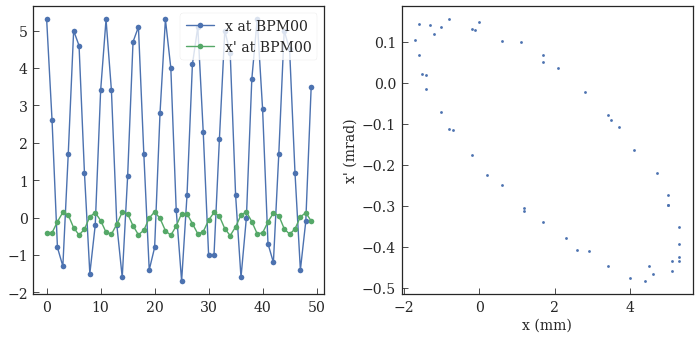

In [34]:
k=2
off = 43
m = 1
ydata1 = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,:50]).values[k] #thisBPM
ydata2 = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m+1,:50]).values[k] #nextBPM

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(ydata1,'o-',label='x at BPM00')

angles = getAngle(Y_TM[m], ydata1, ydata2)

ax[0].plot(angles,'o-',label='x\' at BPM00')
ax[0].legend(frameon=True, loc=1)

ax[1].plot(ydata1, angles,'.')
ax[1].set_xlabel('x (mm)')
ax[1].set_ylabel('x\' (mrad)')

fig.tight_layout()

In [35]:
angles

array([-0.42531375, -0.40661984, -0.11144783,  0.1408038 ,  0.06910188,
       -0.27229594, -0.46553332, -0.31204185,  0.02334974,  0.13257042,
       -0.07848412, -0.39197715, -0.4451867 , -0.17579311,  0.14380692,
        0.10011056, -0.21928792, -0.45942632, -0.33927144, -0.01376595,
        0.15524495, -0.02247299, -0.3503064 , -0.47619538, -0.22424606,
        0.10591526,  0.10233771, -0.16327679, -0.43442387, -0.37861428,
       -0.07055305,  0.13780068,  0.03731723, -0.29729839, -0.48297759,
       -0.24769657,  0.06879957,  0.15001469, -0.10648969, -0.4336479 ,
       -0.40962296, -0.11522692,  0.12035641,  0.05243358, -0.29729839,
       -0.44508593, -0.3037077 ,  0.01957065,  0.12879133, -0.09059736])

# Calculate injection oscillation from the BPM


!!! It's all modified, beatx and alfx are actually the vertical values !

## 1. Look at one BPM and calculate the oscillation over the first 50 turns

In [48]:
# loop over all the BPM --> in vertical ! 
verticalMode = True

if verticalMode:
    off = 43
else:
    off = 0

chi2_thr = 0.5    
    
# fit an harmonic function through the oscillations and extrapolate the amplitude. 
# possible tunes (non integer part) have been restricted to be between .20 and .25 --> 2pi/5 and pi/2

from scipy.optimize import curve_fit
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
osc_amplitude = np.empty([len(myDataFrame),len(BPM_name)],dtype=float); osc_amplitude[:]=np.nan

# statistical check
chi2 = np.empty([len(myDataFrame),len(BPM_name)],dtype=float)

for m in range(len(BPM_name)):

    for k in range(len(myDataFrame)):
        ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,0:30]).values[k]
        # starting values
        phase = 0.33*pi
        p0 = ([1.5*np.std(ydata), phase, -pi/2, np.mean(ydata)])
        # fit boundaries 
        bounds=([0.5*np.std(ydata), .8*pi/5, -pi, -np.inf],[3*np.std(ydata),pi/2.,pi,np.inf])

        try:
            p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
            osc_amplitude[k,m] = np.abs(p[0])

            yfit = f_to_fit(xdata, *p)
            chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)
            while chi2[k,m] > chi2_thr:
                print('chi2 = '+str(chi2[k,m])+' exceding the limit')

                phase += 0.03
                p0 = ([1.5*np.std(ydata), phase, -pi/2, np.mean(ydata)])
                p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
                osc_amplitude[k,m] = np.abs(p[0])

                yfit = f_to_fit(xdata, *p)
                chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)
                print('Refitting, new chi2 = '+str(chi2[k,m]))
                
                if phase > 0.45*pi:
                    print('END phase reached')
                    raise RuntimeError


        except RuntimeError:
            print 'fit do not converge on shot '+str(k)
            osc_amplitude[k,m] = np.nan
            chi2[k,m] = np.nan
        
    print BPM_name[m] + ' processed with success '+ str(np.count_nonzero(~np.isnan(osc_amplitude[:,m]))) +'/'+str(len(myDataFrame))+' shots'
            
print 'Done.'

chi2 = 13.1552236886 exceding the limit
Refitting, new chi2 = 0.0223442573079
chi2 = 12.9982494684 exceding the limit
Refitting, new chi2 = 0.019618761885
chi2 = 13.5154943813 exceding the limit
Refitting, new chi2 = 0.00901803803173
chi2 = 13.2523024735 exceding the limit
Refitting, new chi2 = 0.0229086022712
chi2 = 12.9396576579 exceding the limit
Refitting, new chi2 = 0.0129407271688
chi2 = 12.832452901 exceding the limit
Refitting, new chi2 = 0.0219940074715
chi2 = 13.2595524751 exceding the limit
Refitting, new chi2 = 0.00825445890316
chi2 = 13.2323717066 exceding the limit
Refitting, new chi2 = 0.0205874115112
chi2 = 13.1335857819 exceding the limit
Refitting, new chi2 = 0.0118108643419
chi2 = 13.1011715126 exceding the limit
Refitting, new chi2 = 0.00991069454856
chi2 = 8.27888694619 exceding the limit
Refitting, new chi2 = 0.0100527653282
chi2 = 8.26710945283 exceding the limit
Refitting, new chi2 = 0.00971661073327
chi2 = 8.17396381077 exceding the limit
Refitting, new chi2 = 

PR.BPM03 processed with success 109/109 shots
PR.BPM05 processed with success 109/109 shots
chi2 = 0.770090388733 exceding the limit
Refitting, new chi2 = 0.00613884175361
chi2 = 0.689931784629 exceding the limit
Refitting, new chi2 = 0.00498764186022
chi2 = 0.671320887579 exceding the limit
Refitting, new chi2 = 0.00524946980799
chi2 = 0.726176389494 exceding the limit
Refitting, new chi2 = 0.00862505238394
chi2 = 0.763913011328 exceding the limit
Refitting, new chi2 = 0.00829588279553
chi2 = 0.658458763664 exceding the limit
Refitting, new chi2 = 0.00626503341945
chi2 = 0.653560542585 exceding the limit
Refitting, new chi2 = 0.00723424252118
chi2 = 0.6556367163 exceding the limit
Refitting, new chi2 = 0.00528126340726
chi2 = 0.660254376671 exceding the limit
Refitting, new chi2 = 0.00552612469248
chi2 = 0.774985918944 exceding the limit
Refitting, new chi2 = 0.00734086534565
chi2 = 2.04981681766 exceding the limit
Refitting, new chi2 = 0.00474885542143
chi2 = 2.05500675636 exceding t

Refitting, new chi2 = 0.00986659142006
chi2 = 4.88242662438 exceding the limit
Refitting, new chi2 = 4.88242662297
chi2 = 4.88242662297 exceding the limit
Refitting, new chi2 = 0.00728133247385
chi2 = 4.97201330192 exceding the limit
Refitting, new chi2 = 4.97201330137
chi2 = 4.97201330137 exceding the limit
Refitting, new chi2 = 0.00695902475395
chi2 = 5.07510644779 exceding the limit
Refitting, new chi2 = 5.07510644641
chi2 = 5.07510644641 exceding the limit
Refitting, new chi2 = 11.426700224
chi2 = 11.426700224 exceding the limit
Refitting, new chi2 = 0.00848460577777
chi2 = 4.87421579178 exceding the limit
Refitting, new chi2 = 4.87421579179
chi2 = 4.87421579179 exceding the limit
Refitting, new chi2 = 0.00554384000016
chi2 = 7.64725773527 exceding the limit
Refitting, new chi2 = 7.64725773467
chi2 = 7.64725773467 exceding the limit
Refitting, new chi2 = 0.00775127921916
chi2 = 7.71434125832 exceding the limit
Refitting, new chi2 = 7.7143412558
chi2 = 7.7143412558 exceding the limi

Refitting, new chi2 = 12.774354851
chi2 = 12.774354851 exceding the limit
Refitting, new chi2 = 0.00586202428791
chi2 = 3.1108430321 exceding the limit
Refitting, new chi2 = 3.11084303213
chi2 = 3.11084303213 exceding the limit
Refitting, new chi2 = 3.1108430321
chi2 = 3.1108430321 exceding the limit
Refitting, new chi2 = 12.9803024635
chi2 = 12.9803024635 exceding the limit
Refitting, new chi2 = 0.00918265354038
chi2 = 2.08591454788 exceding the limit
Refitting, new chi2 = 2.08591454789
chi2 = 2.08591454789 exceding the limit
Refitting, new chi2 = 2.08591454787
chi2 = 2.08591454787 exceding the limit
Refitting, new chi2 = 8.07397271224
chi2 = 8.07397271224 exceding the limit
Refitting, new chi2 = 0.0108305429608
chi2 = 1.95852333619 exceding the limit
Refitting, new chi2 = 1.95852333619
chi2 = 1.95852333619 exceding the limit
Refitting, new chi2 = 1.95852333618
chi2 = 1.95852333618 exceding the limit
Refitting, new chi2 = 8.08871829581
chi2 = 8.08871829581 exceding the limit
Refitting

Refitting, new chi2 = 0.00413679016277
PR.BPM20 processed with success 109/109 shots
chi2 = 0.601946083417 exceding the limit
Refitting, new chi2 = 0.00414855059681
chi2 = 0.575454227958 exceding the limit
Refitting, new chi2 = 0.00396991895531
chi2 = 0.56669289902 exceding the limit
Refitting, new chi2 = 0.00659837940693
chi2 = 0.554466967887 exceding the limit
Refitting, new chi2 = 0.00430219433442
chi2 = 0.622622867956 exceding the limit
Refitting, new chi2 = 0.00364073625204
chi2 = 0.556480203733 exceding the limit
Refitting, new chi2 = 0.00370587832878
chi2 = 0.527168626358 exceding the limit
Refitting, new chi2 = 0.00478321110844
chi2 = 0.555846894111 exceding the limit
Refitting, new chi2 = 0.00410534253627
chi2 = 0.562951640203 exceding the limit
Refitting, new chi2 = 0.00717033018488
chi2 = 0.614092935508 exceding the limit
Refitting, new chi2 = 0.00452783762276
chi2 = 1.65059295598 exceding the limit
Refitting, new chi2 = 0.00464024933974
chi2 = 1.63236617358 exceding the lim

Refitting, new chi2 = 9.25910124758
chi2 = 9.25910124758 exceding the limit
Refitting, new chi2 = 0.0112006548322
chi2 = 6.56445615137 exceding the limit
Refitting, new chi2 = 9.25919124786
chi2 = 9.25919124786 exceding the limit
Refitting, new chi2 = 0.0132648462468
chi2 = 6.60007967189 exceding the limit
Refitting, new chi2 = 9.4661188901
chi2 = 9.4661188901 exceding the limit
Refitting, new chi2 = 0.0100707858814
chi2 = 6.56131273238 exceding the limit
Refitting, new chi2 = 0.0125616412575
chi2 = 6.55653981803 exceding the limit
Refitting, new chi2 = 9.24624637268
chi2 = 9.24624637268 exceding the limit
Refitting, new chi2 = 0.0116633608871
chi2 = 6.59849713844 exceding the limit
Refitting, new chi2 = 9.43311660366
chi2 = 9.43311660366 exceding the limit
Refitting, new chi2 = 0.0122359757788
chi2 = 6.60535268093 exceding the limit
Refitting, new chi2 = 9.3252535859
chi2 = 9.3252535859 exceding the limit
Refitting, new chi2 = 0.00864935869203
chi2 = 6.90443226546 exceding the limit
R

Refitting, new chi2 = 0.0128374017558
chi2 = 2.71776192852 exceding the limit
Refitting, new chi2 = 2.71776192847
chi2 = 2.71776192847 exceding the limit
Refitting, new chi2 = 2.71776192858
chi2 = 2.71776192858 exceding the limit
Refitting, new chi2 = 9.04859551398
chi2 = 9.04859551398 exceding the limit
Refitting, new chi2 = 0.00872788878249
chi2 = 2.7000153195 exceding the limit
Refitting, new chi2 = 2.70001531936
chi2 = 2.70001531936 exceding the limit
Refitting, new chi2 = 2.70001531936
chi2 = 2.70001531936 exceding the limit
Refitting, new chi2 = 9.07762637673
chi2 = 9.07762637673 exceding the limit
Refitting, new chi2 = 0.00698039004602
chi2 = 2.80146348199 exceding the limit
Refitting, new chi2 = 2.80146348196
chi2 = 2.80146348196 exceding the limit
Refitting, new chi2 = 2.80146348202
chi2 = 2.80146348202 exceding the limit
Refitting, new chi2 = 0.0122394110238
PR.BPM27 processed with success 109/109 shots
PR.BPM30 processed with success 109/109 shots
chi2 = 8.18599685569 excedi

Refitting, new chi2 = 0.567708310368
chi2 = 0.567708310368 exceding the limit
Refitting, new chi2 = 0.0057046728918
chi2 = 0.52172595173 exceding the limit
Refitting, new chi2 = 0.521725951711
chi2 = 0.521725951711 exceding the limit
Refitting, new chi2 = 0.00340283017703
chi2 = 0.552237025478 exceding the limit
Refitting, new chi2 = 0.552237025618
chi2 = 0.552237025618 exceding the limit
Refitting, new chi2 = 0.00513063238448
chi2 = 0.554307195474 exceding the limit
Refitting, new chi2 = 0.554307195466
chi2 = 0.554307195466 exceding the limit
Refitting, new chi2 = 0.0036784878025
chi2 = 0.511739870167 exceding the limit
Refitting, new chi2 = 0.806128660768
chi2 = 0.806128660768 exceding the limit
Refitting, new chi2 = 0.00811916120172
chi2 = 0.547655045899 exceding the limit
Refitting, new chi2 = 0.547655045515
chi2 = 0.547655045515 exceding the limit
Refitting, new chi2 = 0.00510526230888
chi2 = 0.543550450092 exceding the limit
Refitting, new chi2 = 0.832007485691
chi2 = 0.832007485

chi2 = 7.78165372097 exceding the limit
Refitting, new chi2 = 0.00941017298979
chi2 = 7.54098398006 exceding the limit
Refitting, new chi2 = 0.00647655107527
chi2 = 12.4263090559 exceding the limit
Refitting, new chi2 = 0.0129524533256
chi2 = 12.4299335992 exceding the limit
Refitting, new chi2 = 0.0118644621502
chi2 = 12.1246521704 exceding the limit
Refitting, new chi2 = 0.00826803859351
chi2 = 12.0620532613 exceding the limit
Refitting, new chi2 = 0.00612205597419
chi2 = 11.9876838014 exceding the limit
Refitting, new chi2 = 0.0119814090771
chi2 = 11.7753216381 exceding the limit
Refitting, new chi2 = 0.00931311816531
chi2 = 12.2150483904 exceding the limit
Refitting, new chi2 = 0.00983374664906
chi2 = 12.3658104645 exceding the limit
Refitting, new chi2 = 0.0146623582944
chi2 = 12.4010410025 exceding the limit
Refitting, new chi2 = 0.00666840511264
chi2 = 12.2762829435 exceding the limit
Refitting, new chi2 = 0.0118477213552
chi2 = 18.4063714596 exceding the limit
Refitting, new ch

Refitting, new chi2 = 3.27011899863
chi2 = 3.27011899863 exceding the limit
Refitting, new chi2 = 0.00894095829002
chi2 = 3.31969578959 exceding the limit
Refitting, new chi2 = 3.31969579006
chi2 = 3.31969579006 exceding the limit
Refitting, new chi2 = 0.00870997884238
chi2 = 3.32290599717 exceding the limit
Refitting, new chi2 = 3.3229059973
chi2 = 3.3229059973 exceding the limit
Refitting, new chi2 = 0.0119143159179
chi2 = 3.30372029995 exceding the limit
Refitting, new chi2 = 3.30372030056
chi2 = 3.30372030056 exceding the limit
Refitting, new chi2 = 0.00819286438841
chi2 = 3.34419138995 exceding the limit
Refitting, new chi2 = 3.34419138993
chi2 = 3.34419138993 exceding the limit
Refitting, new chi2 = 0.00628418334864
chi2 = 3.40475957713 exceding the limit
Refitting, new chi2 = 3.40475957659
chi2 = 3.40475957659 exceding the limit
Refitting, new chi2 = 0.00782890300095
chi2 = 3.40052831755 exceding the limit
Refitting, new chi2 = 3.40052831643
chi2 = 3.40052831643 exceding the lim

Refitting, new chi2 = 0.975911122786
chi2 = 0.975911122786 exceding the limit
Refitting, new chi2 = 0.975911122786
chi2 = 0.975911122786 exceding the limit
Refitting, new chi2 = 0.975911122786
chi2 = 0.975911122786 exceding the limit
Refitting, new chi2 = 6.24844354021
chi2 = 6.24844354021 exceding the limit
Refitting, new chi2 = 0.00610232201337
chi2 = 1.020927263 exceding the limit
Refitting, new chi2 = 1.02092726301
chi2 = 1.02092726301 exceding the limit
Refitting, new chi2 = 1.020927263
chi2 = 1.020927263 exceding the limit
Refitting, new chi2 = 1.020927263
chi2 = 1.020927263 exceding the limit
Refitting, new chi2 = 6.39925211624
chi2 = 6.39925211624 exceding the limit
Refitting, new chi2 = 0.00498326222656
chi2 = 0.997674569332 exceding the limit
Refitting, new chi2 = 0.997674569335
chi2 = 0.997674569335 exceding the limit
Refitting, new chi2 = 0.997674569332
chi2 = 0.997674569332 exceding the limit
Refitting, new chi2 = 0.997674569332
chi2 = 0.997674569332 exceding the limit
Ref

Refitting, new chi2 = 0.012703005686
chi2 = 0.904994850529 exceding the limit
Refitting, new chi2 = 0.0156225690718
chi2 = 0.954747016442 exceding the limit
Refitting, new chi2 = 0.0161490778629
chi2 = 0.904680101753 exceding the limit
Refitting, new chi2 = 0.0172695251041
chi2 = 0.880423333922 exceding the limit
Refitting, new chi2 = 0.0256143387828
chi2 = 0.999773085133 exceding the limit
Refitting, new chi2 = 0.0189170706336
chi2 = 0.936073533788 exceding the limit
Refitting, new chi2 = 0.0177924707435
PR.BPM53 processed with success 109/109 shots
chi2 = 6.30440374985 exceding the limit
Refitting, new chi2 = 6.30440374963
chi2 = 6.30440374963 exceding the limit
Refitting, new chi2 = 0.00939433050563
chi2 = 6.32331192003 exceding the limit
Refitting, new chi2 = 6.32331191992
chi2 = 6.32331191992 exceding the limit
Refitting, new chi2 = 0.0106249350584
chi2 = 6.39020809065 exceding the limit
Refitting, new chi2 = 6.39020809096
chi2 = 6.39020809096 exceding the limit
Refitting, new chi

chi2 = 2.13891693695 exceding the limit
Refitting, new chi2 = 2.13891693684
chi2 = 2.13891693684 exceding the limit
Refitting, new chi2 = 2.13891693678
chi2 = 2.13891693678 exceding the limit
Refitting, new chi2 = 0.00345692590887
chi2 = 2.10540616609 exceding the limit
Refitting, new chi2 = 2.10540616611
chi2 = 2.10540616611 exceding the limit
Refitting, new chi2 = 2.10540616609
chi2 = 2.10540616609 exceding the limit
Refitting, new chi2 = 0.00547246548981
chi2 = 2.15357375284 exceding the limit
Refitting, new chi2 = 2.15357375278
chi2 = 2.15357375278 exceding the limit
Refitting, new chi2 = 2.15357375283
chi2 = 2.15357375283 exceding the limit
Refitting, new chi2 = 0.00762726958631
chi2 = 2.1649947866 exceding the limit
Refitting, new chi2 = 2.16499478675
chi2 = 2.16499478675 exceding the limit
Refitting, new chi2 = 2.1649947866
chi2 = 2.1649947866 exceding the limit
Refitting, new chi2 = 6.81962382758
chi2 = 6.81962382758 exceding the limit
Refitting, new chi2 = 0.00742935310222
chi

Refitting, new chi2 = 0.00683493611729
chi2 = 4.85612546525 exceding the limit
Refitting, new chi2 = 0.00749806937025
chi2 = 4.74187162319 exceding the limit
Refitting, new chi2 = 0.00925220474563
chi2 = 4.95117983797 exceding the limit
Refitting, new chi2 = 0.00818232370011
chi2 = 4.86248262596 exceding the limit
Refitting, new chi2 = 6.68836795207
chi2 = 6.68836795207 exceding the limit
Refitting, new chi2 = 0.0130587048394
chi2 = 4.84560622583 exceding the limit
Refitting, new chi2 = 6.58066566347
chi2 = 6.58066566347 exceding the limit
Refitting, new chi2 = 0.00886633664973
chi2 = 4.81588598063 exceding the limit
Refitting, new chi2 = 0.0133472572779
chi2 = 4.75858160259 exceding the limit
Refitting, new chi2 = 0.0108820813879
chi2 = 4.85463463027 exceding the limit
Refitting, new chi2 = 0.00897441683047
chi2 = 4.70517168142 exceding the limit
Refitting, new chi2 = 0.00880280710744
chi2 = 7.98997588045 exceding the limit
Refitting, new chi2 = 0.00914391154618
chi2 = 7.98196259635 e

Refitting, new chi2 = 5.90934545267
chi2 = 5.90934545267 exceding the limit
Refitting, new chi2 = 0.00589840456892
chi2 = 1.18576702655 exceding the limit
Refitting, new chi2 = 1.18576702656
chi2 = 1.18576702656 exceding the limit
Refitting, new chi2 = 1.18576702655
chi2 = 1.18576702655 exceding the limit
Refitting, new chi2 = 5.76364554162
chi2 = 5.76364554162 exceding the limit
Refitting, new chi2 = 0.00563917291509
chi2 = 1.89168652907 exceding the limit
Refitting, new chi2 = 1.89168652908
chi2 = 1.89168652908 exceding the limit
Refitting, new chi2 = 1.89168652909
chi2 = 1.89168652909 exceding the limit
Refitting, new chi2 = 8.94352207885
chi2 = 8.94352207885 exceding the limit
Refitting, new chi2 = 0.00673321538425
chi2 = 1.94093888329 exceding the limit
Refitting, new chi2 = 1.94093888333
chi2 = 1.94093888333 exceding the limit
Refitting, new chi2 = 1.94093888329
chi2 = 1.94093888329 exceding the limit
Refitting, new chi2 = 8.84273319702
chi2 = 8.84273319702 exceding the limit
Ref

Refitting, new chi2 = 14.2479988522
chi2 = 14.2479988522 exceding the limit
Refitting, new chi2 = 14.2479988517
chi2 = 14.2479988517 exceding the limit
Refitting, new chi2 = 0.00812828147351
chi2 = 1.00983656619 exceding the limit
Refitting, new chi2 = 1.00983656619
chi2 = 1.00983656619 exceding the limit
Refitting, new chi2 = 1.00983656619
chi2 = 1.00983656619 exceding the limit
Refitting, new chi2 = 1.00983656619
chi2 = 1.00983656619 exceding the limit
Refitting, new chi2 = 14.4725893954
chi2 = 14.4725893954 exceding the limit
Refitting, new chi2 = 14.4725893953
chi2 = 14.4725893953 exceding the limit
Refitting, new chi2 = 0.0067103824857
chi2 = 1.03684154303 exceding the limit
Refitting, new chi2 = 1.03684154303
chi2 = 1.03684154303 exceding the limit
Refitting, new chi2 = 1.03684154303
chi2 = 1.03684154303 exceding the limit
Refitting, new chi2 = 1.03684154303
chi2 = 1.03684154303 exceding the limit
Refitting, new chi2 = 14.3181511589
chi2 = 14.3181511589 exceding the limit
Refitti

chi2 = 5.47964462853 exceding the limit
Refitting, new chi2 = 5.47964462782
chi2 = 5.47964462782 exceding the limit
Refitting, new chi2 = 0.00889430127661
chi2 = 5.60600549943 exceding the limit
Refitting, new chi2 = 5.60600550069
chi2 = 5.60600550069 exceding the limit
Refitting, new chi2 = 0.00988504646131
chi2 = 3.56658112724 exceding the limit
Refitting, new chi2 = 3.56658112547
chi2 = 3.56658112547 exceding the limit
Refitting, new chi2 = 0.00707448272129
chi2 = 3.47111419857 exceding the limit
Refitting, new chi2 = 3.47111419847
chi2 = 3.47111419847 exceding the limit
Refitting, new chi2 = 0.0110172102239
chi2 = 3.53759949089 exceding the limit
Refitting, new chi2 = 3.53759948929
chi2 = 3.53759948929 exceding the limit
Refitting, new chi2 = 0.00546689987548
chi2 = 3.57863999363 exceding the limit
Refitting, new chi2 = 3.57863999364
chi2 = 3.57863999364 exceding the limit
Refitting, new chi2 = 0.00673016469155
chi2 = 3.55078216645 exceding the limit
Refitting, new chi2 = 3.5507821

Refitting, new chi2 = 0.00494499377617
chi2 = 8.3128360767 exceding the limit
Refitting, new chi2 = 0.00725049438625
chi2 = 8.31658481641 exceding the limit
Refitting, new chi2 = 0.00627902079697
chi2 = 8.52311744833 exceding the limit
Refitting, new chi2 = 0.00671616744416
chi2 = 8.49776501411 exceding the limit
Refitting, new chi2 = 0.00663039423521
chi2 = 8.18284020139 exceding the limit
Refitting, new chi2 = 0.0101877558427
chi2 = 8.52829350068 exceding the limit
Refitting, new chi2 = 0.00655847980305
chi2 = 8.39019656238 exceding the limit
Refitting, new chi2 = 0.0065041204858
chi2 = 8.59920855053 exceding the limit
Refitting, new chi2 = 0.00811553961242
PR.BPM75 processed with success 109/109 shots
chi2 = 0.912652378325 exceding the limit
Refitting, new chi2 = 0.912652378183
chi2 = 0.912652378183 exceding the limit
Refitting, new chi2 = 0.00790587635927
chi2 = 0.914022917916 exceding the limit
Refitting, new chi2 = 0.914022917877
chi2 = 0.914022917877 exceding the limit
Refitting

chi2 = 0.54129469724 exceding the limit
Refitting, new chi2 = 0.54129469724
chi2 = 0.54129469724 exceding the limit
Refitting, new chi2 = 0.54129469724
chi2 = 0.54129469724 exceding the limit
Refitting, new chi2 = 0.541294697241
chi2 = 0.541294697241 exceding the limit
Refitting, new chi2 = 7.15944930101
chi2 = 7.15944930101 exceding the limit
Refitting, new chi2 = 7.15944930109
chi2 = 7.15944930109 exceding the limit
Refitting, new chi2 = 0.00662454266106
chi2 = 0.530992324903 exceding the limit
Refitting, new chi2 = 0.530992324903
chi2 = 0.530992324903 exceding the limit
Refitting, new chi2 = 0.530992324903
chi2 = 0.530992324903 exceding the limit
Refitting, new chi2 = 0.530992324903
chi2 = 0.530992324903 exceding the limit
Refitting, new chi2 = 7.40150070638
chi2 = 7.40150070638 exceding the limit
Refitting, new chi2 = 7.40150070626
chi2 = 7.40150070626 exceding the limit
Refitting, new chi2 = 0.00524846064551
chi2 = 0.509310132145 exceding the limit
Refitting, new chi2 = 0.50931013

Refitting, new chi2 = 1.55162665825
chi2 = 1.55162665825 exceding the limit
Refitting, new chi2 = 17.5768184827
chi2 = 17.5768184827 exceding the limit
Refitting, new chi2 = 17.5768184837
chi2 = 17.5768184837 exceding the limit
Refitting, new chi2 = 0.0122619633809
chi2 = 1.55696766623 exceding the limit
Refitting, new chi2 = 1.55696766623
chi2 = 1.55696766623 exceding the limit
Refitting, new chi2 = 1.55696766623
chi2 = 1.55696766623 exceding the limit
Refitting, new chi2 = 1.55696766623
chi2 = 1.55696766623 exceding the limit
Refitting, new chi2 = 18.0040555456
chi2 = 18.0040555456 exceding the limit
Refitting, new chi2 = 18.0040555438
chi2 = 18.0040555438 exceding the limit
Refitting, new chi2 = 0.00782040877826
PR.BPM80 processed with success 109/109 shots
chi2 = 6.25696464017 exceding the limit
Refitting, new chi2 = 0.00758034350158
chi2 = 6.36177290632 exceding the limit
Refitting, new chi2 = 0.0111226859532
chi2 = 6.35476424788 exceding the limit
Refitting, new chi2 = 0.00531418

Refitting, new chi2 = 1.37970853482
chi2 = 1.37970853482 exceding the limit
Refitting, new chi2 = 1.37970853485
chi2 = 1.37970853485 exceding the limit
Refitting, new chi2 = 0.00644555914664
chi2 = 1.35433043951 exceding the limit
Refitting, new chi2 = 1.35433043951
chi2 = 1.35433043951 exceding the limit
Refitting, new chi2 = 1.35433043952
chi2 = 1.35433043952 exceding the limit
Refitting, new chi2 = 0.00393474204765
chi2 = 1.3518099263 exceding the limit
Refitting, new chi2 = 1.35180992644
chi2 = 1.35180992644 exceding the limit
Refitting, new chi2 = 1.35180992631
chi2 = 1.35180992631 exceding the limit
Refitting, new chi2 = 0.00298174717583
chi2 = 0.793982573617 exceding the limit
Refitting, new chi2 = 0.793982573605
chi2 = 0.793982573605 exceding the limit
Refitting, new chi2 = 0.793982573603
chi2 = 0.793982573603 exceding the limit
Refitting, new chi2 = 0.00476960505145
chi2 = 0.791419991679 exceding the limit
Refitting, new chi2 = 0.791419991671
chi2 = 0.791419991671 exceding the

Refitting, new chi2 = 7.9263220622
chi2 = 7.9263220622 exceding the limit
Refitting, new chi2 = 0.00606201617481
chi2 = 5.34476301718 exceding the limit
Refitting, new chi2 = 8.02780023298
chi2 = 8.02780023298 exceding the limit
Refitting, new chi2 = 0.00993015735443
chi2 = 5.40221598042 exceding the limit
Refitting, new chi2 = 8.22684980385
chi2 = 8.22684980385 exceding the limit
Refitting, new chi2 = 0.00595872816816
chi2 = 5.41826815559 exceding the limit
Refitting, new chi2 = 8.20494042359
chi2 = 8.20494042359 exceding the limit
Refitting, new chi2 = 0.0124960263263
chi2 = 5.16725180538 exceding the limit
Refitting, new chi2 = 7.76178111222
chi2 = 7.76178111222 exceding the limit
Refitting, new chi2 = 0.0093482844259
chi2 = 5.37155356943 exceding the limit
Refitting, new chi2 = 8.16897801494
chi2 = 8.16897801494 exceding the limit
Refitting, new chi2 = 0.00581200725846
chi2 = 5.25143866264 exceding the limit
Refitting, new chi2 = 8.019028372
chi2 = 8.019028372 exceding the limit
Re

Refitting, new chi2 = 2.48769540542
chi2 = 2.48769540542 exceding the limit
Refitting, new chi2 = 8.56403575198
chi2 = 8.56403575198 exceding the limit
Refitting, new chi2 = 0.00710738821064
chi2 = 2.42504063544 exceding the limit
Refitting, new chi2 = 2.42504063542
chi2 = 2.42504063542 exceding the limit
Refitting, new chi2 = 2.42504063543
chi2 = 2.42504063543 exceding the limit
Refitting, new chi2 = 8.64181000961
chi2 = 8.64181000961 exceding the limit
Refitting, new chi2 = 0.00537146005167
chi2 = 2.47676265914 exceding the limit
Refitting, new chi2 = 2.47676265912
chi2 = 2.47676265912 exceding the limit
Refitting, new chi2 = 2.47676265912
chi2 = 2.47676265912 exceding the limit
Refitting, new chi2 = 8.71243128068
chi2 = 8.71243128068 exceding the limit
Refitting, new chi2 = 0.00734610698763
chi2 = 2.46429361737 exceding the limit
Refitting, new chi2 = 2.46429361736
chi2 = 2.46429361736 exceding the limit
Refitting, new chi2 = 2.46429361743
chi2 = 2.46429361743 exceding the limit
Ref

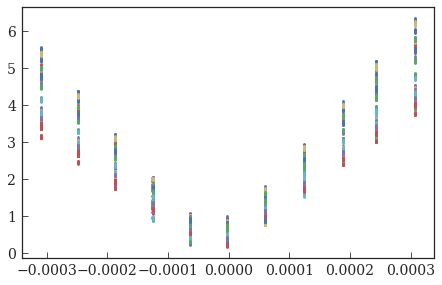

In [49]:
# sanity check 
for k in range(34):
# k=5
    plt.plot(myDataFrame['DVT50_kick'],osc_amplitude[:,k],'.')
    x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,10))

[-1.15616247  1.09502006 -1.74303342  0.35110017]
0.389275627696


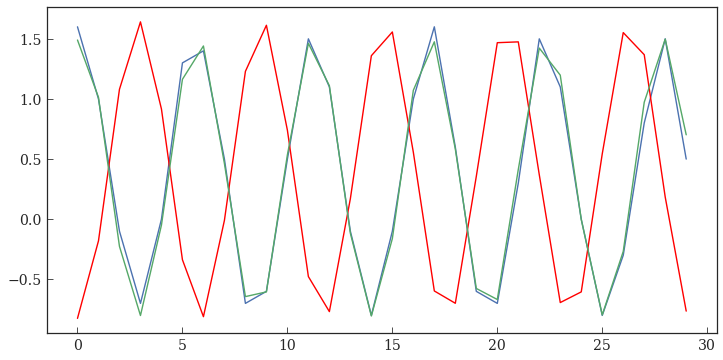

In [50]:
k = 65
m = 10 #bpm number

fig, ax  = plt.subplots(1,figsize=(12,6))
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[off+m,0:30]).values[k]
ax.plot(ydata,'-')

p0 = ([1.5*np.std(ydata), 0.33*pi, -pi/2, np.mean(ydata)])
ax.plot(f_to_fit(xdata, *p0), 'r')

bounds=([-np.inf, 0.01*pi, -pi, -np.inf],[np.inf,pi/2.,pi,np.inf])

p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)

yfit = f_to_fit(xdata, *p)

ax.plot(yfit)

print(p)

print(chi2[k,m])

Beta_x at PR.BPM25: 22.65932139


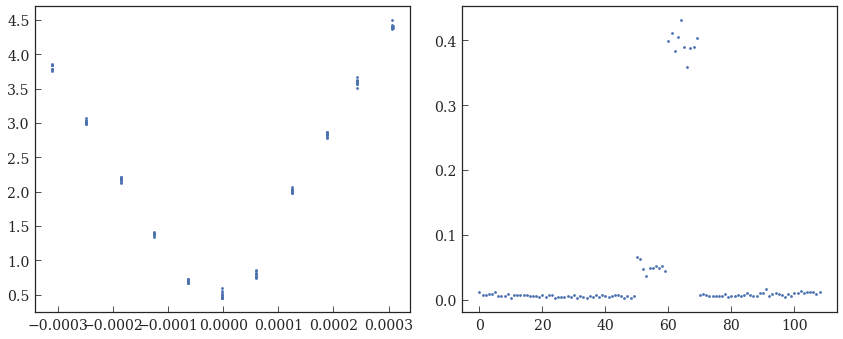

In [51]:
# manual inspection
bpm_n = 10
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(myDataFrame['DVT50_kick'],osc_amplitude[:,bpm_n],'.')
print 'Beta_x at '+BPM_name[bpm_n]+': '+str(BPM_betax[bpm_n])

ax[1].plot(chi2[:,bpm_n],'.')

fig.tight_layout()

2.03833333333
1.13833333333


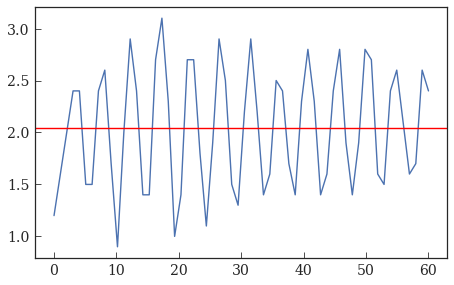

In [52]:
# another manual inspection
mySlice = chi2[:,bpm_n]
ll = np.where(mySlice>.3)
# print chi2[ll,bpm_n]

xdata = np.linspace(0,60,60)
ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[bpm_n,0:60]).values[ll][0]

plt.plot(xdata, ydata,'-',label='data') #factors are to adjust units in the plot

print(np.mean(ydata))
plt.axhline(y=np.mean(ydata),color='r')
print(np.max(np.abs(ydata-np.mean(ydata))))

Text(0,0.5,u'Shot number')

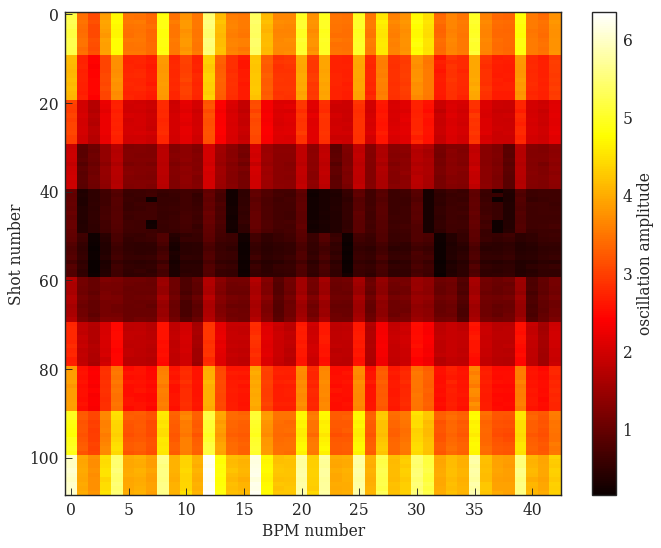

In [53]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(osc_amplitude[:,:],
           cmap='hot',
           aspect='auto'
          )
plt.colorbar(label='oscillation amplitude')
plt.xlabel('BPM number')
plt.ylabel('Shot number')

## Calculate the angle oscillations

In [54]:
# loop over all the BPM --> in vertical ! 
chi2_thr = 4e-4    
    
# fit an harmonic function through the oscillations and extrapolate the amplitude. 
# possible tunes (non integer part) have been restricted to be between .20 and .25 --> 2pi/5 and pi/2

from scipy.optimize import curve_fit
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
osc_amplitude_angle = np.empty([len(myDataFrame),len(BPM_name)],dtype=float); osc_amplitude_angle[:]=np.nan

# statistical check
chi2 = np.empty([len(myDataFrame),len(BPM_name)],dtype=float)

for m in range(len(BPM_name)):

    for k in range(len(myDataFrame)):
        ydata = myDataFrame['BPMy_angle'].iloc[k][m,0:30]
        # starting values
        phase = 0.33*pi
        p0 = ([1.5*np.std(ydata), phase, -pi/2, np.mean(ydata)])
        # fit boundaries 
        bounds=([0.5*np.std(ydata), .8*pi/5, -pi, -np.inf],[3*np.std(ydata),pi/2.,pi,np.inf])

        try:
            p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
            osc_amplitude_angle[k,m] = np.abs(p[0])

            yfit = f_to_fit(xdata, *p)
            chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)
            while chi2[k,m] > chi2_thr:
                print('chi2 = '+str(chi2[k,m])+' exceding the limit')
                phase += 0.03
                p0 = ([1.5*np.std(ydata), phase, -pi/2, np.mean(ydata)])
                p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
                osc_amplitude_angle[k,m] = np.abs(p[0])

                yfit = f_to_fit(xdata, *p)
                chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)
                print('Refitting, new chi2 = '+str(chi2[k,m]))
                
                if phase > 0.45*pi:
                    print('END phase reached')
                    raise RuntimeError


        except RuntimeError:
            print 'fit do not converge on shot '+str(k)
            osc_amplitude_angle[k,m] = np.nan
            chi2[k,m] = np.nan
        
    print BPM_name[m] + ' processed with success '+ str(np.count_nonzero(~np.isnan(osc_amplitude_angle[:,m]))) +'/'+str(len(myDataFrame))+' shots'
            
print 'Done.'

chi2 = 0.00085157078697 exceding the limit
Refitting, new chi2 = 0.000851570787035
chi2 = 0.000851570787035 exceding the limit
Refitting, new chi2 = 2.4105793327e-05
chi2 = 0.00076189070904 exceding the limit
Refitting, new chi2 = 0.000761890709145
chi2 = 0.000761890709145 exceding the limit
Refitting, new chi2 = 2.08901554967e-05
chi2 = 0.000614286578392 exceding the limit
Refitting, new chi2 = 0.000614286578221
chi2 = 0.000614286578221 exceding the limit
Refitting, new chi2 = 3.46741808424e-05
chi2 = 0.00057133446466 exceding the limit
Refitting, new chi2 = 0.000571334464709
chi2 = 0.000571334464709 exceding the limit
Refitting, new chi2 = 2.68507006267e-05
chi2 = 0.000641158340059 exceding the limit
Refitting, new chi2 = 0.000641158340057
chi2 = 0.000641158340057 exceding the limit
Refitting, new chi2 = 2.80966965573e-05
chi2 = 0.000759478268255 exceding the limit
Refitting, new chi2 = 0.000759478268313
chi2 = 0.000759478268313 exceding the limit
Refitting, new chi2 = 3.16877050796e

Refitting, new chi2 = 0.00792478975701
chi2 = 0.00792478975701 exceding the limit
Refitting, new chi2 = 0.00010823421976
chi2 = 0.00800802385549 exceding the limit
Refitting, new chi2 = 0.00800802385384
chi2 = 0.00800802385384 exceding the limit
Refitting, new chi2 = 0.000114740185109
chi2 = 0.00729544846896 exceding the limit
Refitting, new chi2 = 0.00729544846958
chi2 = 0.00729544846958 exceding the limit
Refitting, new chi2 = 8.49382985161e-05
chi2 = 0.00714378233057 exceding the limit
Refitting, new chi2 = 0.00714378233261
chi2 = 0.00714378233261 exceding the limit
Refitting, new chi2 = 8.08592844361e-05
chi2 = 0.00745496344703 exceding the limit
Refitting, new chi2 = 0.00745496344683
chi2 = 0.00745496344683 exceding the limit
Refitting, new chi2 = 0.000113290545169
chi2 = 0.00756715634046 exceding the limit
Refitting, new chi2 = 0.00756715634024
chi2 = 0.00756715634024 exceding the limit
Refitting, new chi2 = 4.50958931776e-05
chi2 = 0.0157154985826 exceding the limit
Refitting, n

chi2 = 0.000772591385503 exceding the limit
Refitting, new chi2 = 0.000772591385485
chi2 = 0.000772591385485 exceding the limit
Refitting, new chi2 = 0.000772591385485
chi2 = 0.000772591385485 exceding the limit
Refitting, new chi2 = 0.00405926263709
chi2 = 0.00405926263709 exceding the limit
Refitting, new chi2 = 5.79041643141e-05
chi2 = 0.000738369756759 exceding the limit
Refitting, new chi2 = 0.000738369756759
chi2 = 0.000738369756759 exceding the limit
Refitting, new chi2 = 0.000738369756759
chi2 = 0.000738369756759 exceding the limit
Refitting, new chi2 = 0.000738369756759
chi2 = 0.000738369756759 exceding the limit
Refitting, new chi2 = 0.00386924711508
chi2 = 0.00386924711508 exceding the limit
Refitting, new chi2 = 0.000110057518408
chi2 = 0.000830942090739 exceding the limit
Refitting, new chi2 = 0.000830942090751
chi2 = 0.000830942090751 exceding the limit
Refitting, new chi2 = 0.000830942090739
chi2 = 0.000830942090739 exceding the limit
Refitting, new chi2 = 0.000830942090

Refitting, new chi2 = 0.00011835683017
chi2 = 0.0111536215439 exceding the limit
Refitting, new chi2 = 0.0111536215441
chi2 = 0.0111536215441 exceding the limit
Refitting, new chi2 = 0.0111536215444
chi2 = 0.0111536215444 exceding the limit
Refitting, new chi2 = 8.45044898842e-05
chi2 = 0.0105174226013 exceding the limit
Refitting, new chi2 = 0.0105174226011
chi2 = 0.0105174226011 exceding the limit
Refitting, new chi2 = 0.0105174226013
chi2 = 0.0105174226013 exceding the limit
Refitting, new chi2 = 0.0363625342962
chi2 = 0.0363625342962 exceding the limit
Refitting, new chi2 = 4.17428404672e-05
chi2 = 0.0107656821847 exceding the limit
Refitting, new chi2 = 0.0107656821848
chi2 = 0.0107656821848 exceding the limit
Refitting, new chi2 = 0.0107656821849
chi2 = 0.0107656821849 exceding the limit
Refitting, new chi2 = 0.0353062307465
chi2 = 0.0353062307465 exceding the limit
Refitting, new chi2 = 8.31964563601e-05
chi2 = 0.0115556851875 exceding the limit
Refitting, new chi2 = 0.011555685

Refitting, new chi2 = 0.0156783942517
chi2 = 0.0156783942517 exceding the limit
Refitting, new chi2 = 0.000148511142495
chi2 = 0.016318648444 exceding the limit
Refitting, new chi2 = 0.016318648444
chi2 = 0.016318648444 exceding the limit
Refitting, new chi2 = 0.0163186484445
chi2 = 0.0163186484445 exceding the limit
Refitting, new chi2 = 5.82193333426e-05
chi2 = 0.0169778344902 exceding the limit
Refitting, new chi2 = 0.0169778344902
chi2 = 0.0169778344902 exceding the limit
Refitting, new chi2 = 0.0169778344902
chi2 = 0.0169778344902 exceding the limit
Refitting, new chi2 = 0.00010843998794
chi2 = 0.0161714142156 exceding the limit
Refitting, new chi2 = 0.0161714142156
chi2 = 0.0161714142156 exceding the limit
Refitting, new chi2 = 0.0161714142156
chi2 = 0.0161714142156 exceding the limit
Refitting, new chi2 = 5.96424964711e-05
chi2 = 0.0168187442309 exceding the limit
Refitting, new chi2 = 0.0168187442323
chi2 = 0.0168187442323 exceding the limit
Refitting, new chi2 = 0.016818744230

Refitting, new chi2 = 0.00140665211872
chi2 = 0.00140665211872 exceding the limit
Refitting, new chi2 = 0.000126597094107
chi2 = 0.0010773840484 exceding the limit
Refitting, new chi2 = 0.00160451905683
chi2 = 0.00160451905683 exceding the limit
Refitting, new chi2 = 0.000102952118036
chi2 = 0.00113355572586 exceding the limit
Refitting, new chi2 = 0.00162478771187
chi2 = 0.00162478771187 exceding the limit
Refitting, new chi2 = 7.74413306839e-05
chi2 = 0.000961024022385 exceding the limit
Refitting, new chi2 = 0.00131860646366
chi2 = 0.00131860646366 exceding the limit
Refitting, new chi2 = 9.23683060973e-05
PR.BPM13 processed with success 109/109 shots
chi2 = 0.00317227883663 exceding the limit
Refitting, new chi2 = 0.00317227883663
chi2 = 0.00317227883663 exceding the limit
Refitting, new chi2 = 0.00317227883663
chi2 = 0.00317227883663 exceding the limit
Refitting, new chi2 = 0.00317227883663
chi2 = 0.00317227883663 exceding the limit
Refitting, new chi2 = 0.0420001720341
chi2 = 0.0

Refitting, new chi2 = 0.00186950067048
chi2 = 0.00186950067048 exceding the limit
Refitting, new chi2 = 0.00186950067048
chi2 = 0.00186950067048 exceding the limit
Refitting, new chi2 = 0.0256756369829
chi2 = 0.0256756369829 exceding the limit
Refitting, new chi2 = 0.0256756369851
chi2 = 0.0256756369851 exceding the limit
Refitting, new chi2 = 0.000113693294032
chi2 = 0.00209403241241 exceding the limit
Refitting, new chi2 = 0.00209403241241
chi2 = 0.00209403241241 exceding the limit
Refitting, new chi2 = 0.00209403241241
chi2 = 0.00209403241241 exceding the limit
Refitting, new chi2 = 0.00209403241241
chi2 = 0.00209403241241 exceding the limit
Refitting, new chi2 = 0.0257752372816
chi2 = 0.0257752372816 exceding the limit
Refitting, new chi2 = 0.0257752372848
chi2 = 0.0257752372848 exceding the limit
Refitting, new chi2 = 0.000102549758708
chi2 = 0.00178476187172 exceding the limit
Refitting, new chi2 = 0.00178476187172
chi2 = 0.00178476187172 exceding the limit
Refitting, new chi2 = 

chi2 = 0.00098823317626 exceding the limit
Refitting, new chi2 = 0.00578611031857
chi2 = 0.00578611031857 exceding the limit
Refitting, new chi2 = 8.70775375796e-05
chi2 = 0.000890599582821 exceding the limit
Refitting, new chi2 = 0.000890599582819
chi2 = 0.000890599582819 exceding the limit
Refitting, new chi2 = 0.00089059958282
chi2 = 0.00089059958282 exceding the limit
Refitting, new chi2 = 0.000890599582819
chi2 = 0.000890599582819 exceding the limit
Refitting, new chi2 = 0.00536968820358
chi2 = 0.00536968820358 exceding the limit
Refitting, new chi2 = 5.18527614897e-05
chi2 = 0.000850678542047 exceding the limit
Refitting, new chi2 = 0.000850678542047
chi2 = 0.000850678542047 exceding the limit
Refitting, new chi2 = 0.000850678542047
chi2 = 0.000850678542047 exceding the limit
Refitting, new chi2 = 0.000850678542047
chi2 = 0.000850678542047 exceding the limit
Refitting, new chi2 = 0.00574073497108
chi2 = 0.00574073497108 exceding the limit
Refitting, new chi2 = 0.000133032437071
c

chi2 = 0.0123553924054 exceding the limit
Refitting, new chi2 = 3.20080950024e-05
chi2 = 0.0117899120583 exceding the limit
Refitting, new chi2 = 2.8980063704e-05
chi2 = 0.0123119321188 exceding the limit
Refitting, new chi2 = 2.14039605653e-05
chi2 = 0.0115663255863 exceding the limit
Refitting, new chi2 = 2.54774132315e-05
chi2 = 0.011549464967 exceding the limit
Refitting, new chi2 = 2.1978688674e-05
chi2 = 0.0118957031758 exceding the limit
Refitting, new chi2 = 4.78804004624e-05
chi2 = 0.0116005883365 exceding the limit
Refitting, new chi2 = 3.92245025528e-05
chi2 = 0.0187870132792 exceding the limit
Refitting, new chi2 = 3.57795987105e-05
chi2 = 0.0189291096131 exceding the limit
Refitting, new chi2 = 1.593415538e-05
chi2 = 0.0179349661966 exceding the limit
Refitting, new chi2 = 2.78412160054e-05
chi2 = 0.0182842613458 exceding the limit
Refitting, new chi2 = 2.42046308858e-05
chi2 = 0.0182375619801 exceding the limit
Refitting, new chi2 = 4.32795768838e-05
chi2 = 0.018065390571

Refitting, new chi2 = 0.00244259977408
chi2 = 0.00244259977408 exceding the limit
Refitting, new chi2 = 0.0127281646787
chi2 = 0.0127281646787 exceding the limit
Refitting, new chi2 = 4.16549537463e-05
chi2 = 0.00224843887829 exceding the limit
Refitting, new chi2 = 0.0022484388783
chi2 = 0.0022484388783 exceding the limit
Refitting, new chi2 = 0.00224843887829
chi2 = 0.00224843887829 exceding the limit
Refitting, new chi2 = 0.0128293970561
chi2 = 0.0128293970561 exceding the limit
Refitting, new chi2 = 0.0128293970556
chi2 = 0.0128293970556 exceding the limit
Refitting, new chi2 = 1.79365352495e-05
chi2 = 0.00235245115954 exceding the limit
Refitting, new chi2 = 0.00235245115957
chi2 = 0.00235245115957 exceding the limit
Refitting, new chi2 = 0.00235245115954
chi2 = 0.00235245115954 exceding the limit
Refitting, new chi2 = 0.00235245115954
chi2 = 0.00235245115954 exceding the limit
Refitting, new chi2 = 0.0125857523288
chi2 = 0.0125857523288 exceding the limit
Refitting, new chi2 = 2.

Refitting, new chi2 = 0.0411743447436
chi2 = 0.0411743447436 exceding the limit
Refitting, new chi2 = 5.37493483583e-05
chi2 = 0.0153887757212 exceding the limit
Refitting, new chi2 = 0.0153887757213
chi2 = 0.0153887757213 exceding the limit
Refitting, new chi2 = 0.0153887757212
chi2 = 0.0153887757212 exceding the limit
Refitting, new chi2 = 0.0635956728494
chi2 = 0.0635956728494 exceding the limit
Refitting, new chi2 = 3.37504258476e-05
chi2 = 0.0157118541802 exceding the limit
Refitting, new chi2 = 0.0157118541802
chi2 = 0.0157118541802 exceding the limit
Refitting, new chi2 = 0.0157118541801
chi2 = 0.0157118541801 exceding the limit
Refitting, new chi2 = 0.0622726086123
chi2 = 0.0622726086123 exceding the limit
Refitting, new chi2 = 3.97942824768e-05
chi2 = 0.0149929052693 exceding the limit
Refitting, new chi2 = 0.0149929052693
chi2 = 0.0149929052693 exceding the limit
Refitting, new chi2 = 0.0149929052693
chi2 = 0.0149929052693 exceding the limit
Refitting, new chi2 = 0.0614036604

Refitting, new chi2 = 0.00154150279213
chi2 = 0.00154150279213 exceding the limit
Refitting, new chi2 = 0.00154150279213
chi2 = 0.00154150279213 exceding the limit
Refitting, new chi2 = 0.00154150279213
chi2 = 0.00154150279213 exceding the limit
Refitting, new chi2 = 0.0330920303671
chi2 = 0.0330920303671 exceding the limit
Refitting, new chi2 = 0.0330920303717
chi2 = 0.0330920303717 exceding the limit
Refitting, new chi2 = 0.0330920303698
chi2 = 0.0330920303698 exceding the limit
Refitting, new chi2 = 0.000118656233076
chi2 = 0.00129208381325 exceding the limit
Refitting, new chi2 = 0.00129208381325
chi2 = 0.00129208381325 exceding the limit
Refitting, new chi2 = 0.00129208381325
chi2 = 0.00129208381325 exceding the limit
Refitting, new chi2 = 0.00129208381325
chi2 = 0.00129208381325 exceding the limit
Refitting, new chi2 = 0.0330956592408
chi2 = 0.0330956592408 exceding the limit
Refitting, new chi2 = 0.0330956592413
chi2 = 0.0330956592413 exceding the limit
Refitting, new chi2 = 0.0

Refitting, new chi2 = 0.0482201469898
chi2 = 0.0482201469898 exceding the limit
Refitting, new chi2 = 0.000167894685433
chi2 = 0.00227959858953 exceding the limit
Refitting, new chi2 = 0.00227959858953
chi2 = 0.00227959858953 exceding the limit
Refitting, new chi2 = 0.00227959858953
chi2 = 0.00227959858953 exceding the limit
Refitting, new chi2 = 0.00227959858953
chi2 = 0.00227959858953 exceding the limit
Refitting, new chi2 = 0.0478290365992
chi2 = 0.0478290365992 exceding the limit
Refitting, new chi2 = 0.0478290366041
chi2 = 0.0478290366041 exceding the limit
Refitting, new chi2 = 0.0478290366021
chi2 = 0.0478290366021 exceding the limit
Refitting, new chi2 = 0.000115368231286
PR.BPM23 processed with success 109/109 shots
chi2 = 0.030964905476 exceding the limit
Refitting, new chi2 = 0.000106050946558
PR.BPM25 processed with success 109/109 shots
chi2 = 0.0162545628348 exceding the limit
Refitting, new chi2 = 0.0248823545381
chi2 = 0.0248823545381 exceding the limit
Refitting, new c

chi2 = 0.00359785195242 exceding the limit
Refitting, new chi2 = 0.00359785195242
chi2 = 0.00359785195242 exceding the limit
Refitting, new chi2 = 0.00359785195242
chi2 = 0.00359785195242 exceding the limit
Refitting, new chi2 = 0.00359785195242
chi2 = 0.00359785195242 exceding the limit
Refitting, new chi2 = 0.0532801722481
chi2 = 0.0532801722481 exceding the limit
Refitting, new chi2 = 0.0532801722478
chi2 = 0.0532801722478 exceding the limit
Refitting, new chi2 = 6.12728067961e-05
chi2 = 0.00383614570285 exceding the limit
Refitting, new chi2 = 0.00383614570285
chi2 = 0.00383614570285 exceding the limit
Refitting, new chi2 = 0.00383614570285
chi2 = 0.00383614570285 exceding the limit
Refitting, new chi2 = 0.00383614570285
chi2 = 0.00383614570285 exceding the limit
Refitting, new chi2 = 0.0524757725695
chi2 = 0.0524757725695 exceding the limit
Refitting, new chi2 = 0.0524757725781
chi2 = 0.0524757725781 exceding the limit
Refitting, new chi2 = 4.11732521001e-05
chi2 = 0.0035590318850

chi2 = 0.00179941015419 exceding the limit
Refitting, new chi2 = 0.00179941015419
chi2 = 0.00179941015419 exceding the limit
Refitting, new chi2 = 0.00179941015419
chi2 = 0.00179941015419 exceding the limit
Refitting, new chi2 = 0.00179941015419
chi2 = 0.00179941015419 exceding the limit
Refitting, new chi2 = 0.0171163116569
chi2 = 0.0171163116569 exceding the limit
Refitting, new chi2 = 0.0171163116581
chi2 = 0.0171163116581 exceding the limit
Refitting, new chi2 = 5.3680399737e-05
chi2 = 0.00158385631713 exceding the limit
Refitting, new chi2 = 0.00158385631713
chi2 = 0.00158385631713 exceding the limit
Refitting, new chi2 = 0.00158385631713
chi2 = 0.00158385631713 exceding the limit
Refitting, new chi2 = 0.00158385631713
chi2 = 0.00158385631713 exceding the limit
Refitting, new chi2 = 0.0184076877987
chi2 = 0.0184076877987 exceding the limit
Refitting, new chi2 = 0.0184076877989
chi2 = 0.0184076877989 exceding the limit
Refitting, new chi2 = 3.88099543568e-05
chi2 = 0.00171099220254

Refitting, new chi2 = 0.00201818819002
chi2 = 0.00201818819002 exceding the limit
Refitting, new chi2 = 2.62300583024e-05
chi2 = 0.00052932982481 exceding the limit
Refitting, new chi2 = 0.000529329824809
chi2 = 0.000529329824809 exceding the limit
Refitting, new chi2 = 0.000529329824808
chi2 = 0.000529329824808 exceding the limit
Refitting, new chi2 = 0.00180181221993
chi2 = 0.00180181221993 exceding the limit
Refitting, new chi2 = 3.36485230447e-05
chi2 = 0.000654126525071 exceding the limit
Refitting, new chi2 = 0.000654126525058
chi2 = 0.000654126525058 exceding the limit
Refitting, new chi2 = 0.000654126525057
chi2 = 0.000654126525057 exceding the limit
Refitting, new chi2 = 3.59034061011e-05
chi2 = 0.00062953613591 exceding the limit
Refitting, new chi2 = 0.00062953613591
chi2 = 0.00062953613591 exceding the limit
Refitting, new chi2 = 0.00062953613591
chi2 = 0.00062953613591 exceding the limit
Refitting, new chi2 = 0.00211620274067
chi2 = 0.00211620274067 exceding the limit
Refi

chi2 = 0.0732229209839 exceding the limit
Refitting, new chi2 = 0.000150871889487
chi2 = 0.0756768273654 exceding the limit
Refitting, new chi2 = 0.000206837336463
chi2 = 0.0771635436456 exceding the limit
Refitting, new chi2 = 0.00014751702399
PR.BPM33 processed with success 109/109 shots
chi2 = 0.000657586272377 exceding the limit
Refitting, new chi2 = 0.00065758627238
chi2 = 0.00065758627238 exceding the limit
Refitting, new chi2 = 0.000657586272377
chi2 = 0.000657586272377 exceding the limit
Refitting, new chi2 = 0.00196734349015
chi2 = 0.00196734349015 exceding the limit
Refitting, new chi2 = 7.86830659445e-05
chi2 = 0.000586597826351 exceding the limit
Refitting, new chi2 = 0.000586597826348
chi2 = 0.000586597826348 exceding the limit
Refitting, new chi2 = 0.000586597826349
chi2 = 0.000586597826349 exceding the limit
Refitting, new chi2 = 6.23866497079e-05
chi2 = 0.000576059167355 exceding the limit
Refitting, new chi2 = 0.000576059167375
chi2 = 0.000576059167375 exceding the lim

Refitting, new chi2 = 0.000134983048276
chi2 = 0.0325273458757 exceding the limit
Refitting, new chi2 = 0.0474500234486
chi2 = 0.0474500234486 exceding the limit
Refitting, new chi2 = 0.000109220287705
chi2 = 0.0332068729063 exceding the limit
Refitting, new chi2 = 0.0459810009749
chi2 = 0.0459810009749 exceding the limit
Refitting, new chi2 = 0.000174607415671
chi2 = 0.031399621224 exceding the limit
Refitting, new chi2 = 0.0446789061936
chi2 = 0.0446789061936 exceding the limit
Refitting, new chi2 = 0.000135663757183
chi2 = 0.0316004342881 exceding the limit
Refitting, new chi2 = 0.0458794826218
chi2 = 0.0458794826218 exceding the limit
Refitting, new chi2 = 0.000135372510106
chi2 = 0.0340480327847 exceding the limit
Refitting, new chi2 = 0.0487405301966
chi2 = 0.0487405301966 exceding the limit
Refitting, new chi2 = 0.000121699250281
chi2 = 0.0330867885167 exceding the limit
Refitting, new chi2 = 0.0469895240898
chi2 = 0.0469895240898 exceding the limit
Refitting, new chi2 = 0.00013

Refitting, new chi2 = 0.013930705865
chi2 = 0.013930705865 exceding the limit
Refitting, new chi2 = 1.90411952192e-05
chi2 = 0.00144091807284 exceding the limit
Refitting, new chi2 = 0.00144091807284
chi2 = 0.00144091807284 exceding the limit
Refitting, new chi2 = 0.00144091807284
chi2 = 0.00144091807284 exceding the limit
Refitting, new chi2 = 0.00144091807284
chi2 = 0.00144091807284 exceding the limit
Refitting, new chi2 = 0.0132038070418
chi2 = 0.0132038070418 exceding the limit
Refitting, new chi2 = 0.0132038070431
chi2 = 0.0132038070431 exceding the limit
Refitting, new chi2 = 4.1080554213e-05
chi2 = 0.00141756366041 exceding the limit
Refitting, new chi2 = 0.00141756366041
chi2 = 0.00141756366041 exceding the limit
Refitting, new chi2 = 0.00141756366041
chi2 = 0.00141756366041 exceding the limit
Refitting, new chi2 = 0.00141756366041
chi2 = 0.00141756366041 exceding the limit
Refitting, new chi2 = 0.0138797894344
chi2 = 0.0138797894344 exceding the limit
Refitting, new chi2 = 0.0

Refitting, new chi2 = 4.27547134091e-05
chi2 = 0.0038636706852 exceding the limit
Refitting, new chi2 = 0.0038636706852
chi2 = 0.0038636706852 exceding the limit
Refitting, new chi2 = 0.0038636706852
chi2 = 0.0038636706852 exceding the limit
Refitting, new chi2 = 0.0038636706852
chi2 = 0.0038636706852 exceding the limit
Refitting, new chi2 = 0.0328948113055
chi2 = 0.0328948113055 exceding the limit
Refitting, new chi2 = 0.0328948113047
chi2 = 0.0328948113047 exceding the limit
Refitting, new chi2 = 6.92030401558e-05
chi2 = 0.00436593081006 exceding the limit
Refitting, new chi2 = 0.00436593081006
chi2 = 0.00436593081006 exceding the limit
Refitting, new chi2 = 0.00436593081006
chi2 = 0.00436593081006 exceding the limit
Refitting, new chi2 = 0.00436593081006
chi2 = 0.00436593081006 exceding the limit
Refitting, new chi2 = 0.0336970758202
chi2 = 0.0336970758202 exceding the limit
Refitting, new chi2 = 5.14169112372e-05
chi2 = 0.00431261925741 exceding the limit
Refitting, new chi2 = 0.00

Refitting, new chi2 = 0.000477089880735
chi2 = 0.000477089880735 exceding the limit
Refitting, new chi2 = 0.00249629095905
chi2 = 0.00249629095905 exceding the limit
Refitting, new chi2 = 0.00249629095957
chi2 = 0.00249629095957 exceding the limit
Refitting, new chi2 = 0.00249629095933
chi2 = 0.00249629095933 exceding the limit
Refitting, new chi2 = 0.00249629095739
chi2 = 0.00249629095739 exceding the limit
Refitting, new chi2 = 0.00249629095839
chi2 = 0.00249629095839 exceding the limit
Refitting, new chi2 = 0.00249629095858
END phase reached
fit do not converge on shot 41
chi2 = 0.000451267688789 exceding the limit
Refitting, new chi2 = 0.000451267688791
chi2 = 0.000451267688791 exceding the limit
Refitting, new chi2 = 0.000451267688789
chi2 = 0.000451267688789 exceding the limit
Refitting, new chi2 = 0.000451267688788
chi2 = 0.000451267688788 exceding the limit
Refitting, new chi2 = 0.000451267688788
chi2 = 0.000451267688788 exceding the limit
Refitting, new chi2 = 0.0004512676888


Refitting, new chi2 = 0.0323337183605
chi2 = 0.0323337183605 exceding the limit
Refitting, new chi2 = 0.000505140959728
chi2 = 0.000505140959728 exceding the limit
Refitting, new chi2 = 0.000505140959728
chi2 = 0.000505140959728 exceding the limit
Refitting, new chi2 = 0.0333841488512
chi2 = 0.0333841488512 exceding the limit
Refitting, new chi2 = 0.0333841488518
END phase reached
fit do not converge on shot 88
chi2 = 0.000764763436992 exceding the limit
Refitting, new chi2 = 0.000764763436992
chi2 = 0.000764763436992 exceding the limit
Refitting, new chi2 = 0.000764763436992
chi2 = 0.000764763436992 exceding the limit
Refitting, new chi2 = 0.000764763436992
chi2 = 0.000764763436992 exceding the limit
Refitting, new chi2 = 0.000764763436992
chi2 = 0.000764763436992 exceding the limit
Refitting, new chi2 = 0.0499158431783
chi2 = 0.0499158431783 exceding the limit
Refitting, new chi2 = 0.0499158431735
chi2 = 0.0499158431735 exceding the limit
Refitting, new chi2 = 0.0499158431735
chi2 = 

Refitting, new chi2 = 0.000143319574662
chi2 = 0.0504757650463 exceding the limit
Refitting, new chi2 = 0.000138372495365
chi2 = 0.0514462056692 exceding the limit
Refitting, new chi2 = 9.95380498959e-05
chi2 = 0.0508391461911 exceding the limit
Refitting, new chi2 = 0.000172506400972
chi2 = 0.0520545904456 exceding the limit
Refitting, new chi2 = 0.00014217754935
chi2 = 0.0512249726515 exceding the limit
Refitting, new chi2 = 0.000225602285922
chi2 = 0.0517945329255 exceding the limit
Refitting, new chi2 = 0.000188383865003
chi2 = 0.0326382567161 exceding the limit
Refitting, new chi2 = 9.31570306667e-05
chi2 = 0.0308999612429 exceding the limit
Refitting, new chi2 = 0.000162340646329
chi2 = 0.0318748960556 exceding the limit
Refitting, new chi2 = 0.00010151902963
chi2 = 0.0314560518314 exceding the limit
Refitting, new chi2 = 0.000105456794622
chi2 = 0.0323336850702 exceding the limit
Refitting, new chi2 = 0.000157635698286
chi2 = 0.032268235688 exceding the limit
Refitting, new chi2

Refitting, new chi2 = 3.12584209477e-05
chi2 = 0.000561676733422 exceding the limit
Refitting, new chi2 = 0.000561676733422
chi2 = 0.000561676733422 exceding the limit
Refitting, new chi2 = 0.000561676733422
chi2 = 0.000561676733422 exceding the limit
Refitting, new chi2 = 0.000561676733422
chi2 = 0.000561676733422 exceding the limit
Refitting, new chi2 = 0.0275655518939
chi2 = 0.0275655518939 exceding the limit
Refitting, new chi2 = 0.0275655518951
chi2 = 0.0275655518951 exceding the limit
Refitting, new chi2 = 0.0275655518973
chi2 = 0.0275655518973 exceding the limit
Refitting, new chi2 = 0.0275655518938
chi2 = 0.0275655518938 exceding the limit
Refitting, new chi2 = 2.82422901094e-05
chi2 = 0.000714299971622 exceding the limit
Refitting, new chi2 = 0.000714299971622
chi2 = 0.000714299971622 exceding the limit
Refitting, new chi2 = 0.000714299971622
chi2 = 0.000714299971622 exceding the limit
Refitting, new chi2 = 0.000714299971622
chi2 = 0.000714299971622 exceding the limit
Refittin

Refitting, new chi2 = 0.000619728627465
chi2 = 0.000619728627465 exceding the limit
Refitting, new chi2 = 0.0147317290201
chi2 = 0.0147317290201 exceding the limit
Refitting, new chi2 = 0.0147317290209
chi2 = 0.0147317290209 exceding the limit
Refitting, new chi2 = 0.0147317290212
chi2 = 0.0147317290212 exceding the limit
Refitting, new chi2 = 3.65964280968e-05
chi2 = 0.00054993304515 exceding the limit
Refitting, new chi2 = 0.00054993304515
chi2 = 0.00054993304515 exceding the limit
Refitting, new chi2 = 0.00054993304515
chi2 = 0.00054993304515 exceding the limit
Refitting, new chi2 = 0.00054993304515
chi2 = 0.00054993304515 exceding the limit
Refitting, new chi2 = 0.0146833049792
chi2 = 0.0146833049792 exceding the limit
Refitting, new chi2 = 0.0146833049747
chi2 = 0.0146833049747 exceding the limit
Refitting, new chi2 = 0.0146833049771
chi2 = 0.0146833049771 exceding the limit
Refitting, new chi2 = 2.55078567452e-05
chi2 = 0.000557701726563 exceding the limit
Refitting, new chi2 = 0

chi2 = 0.00383092550265 exceding the limit
Refitting, new chi2 = 3.53345873091e-05
chi2 = 0.00403281895429 exceding the limit
Refitting, new chi2 = 2.54635970269e-05
PR.BPM50 processed with success 109/109 shots
chi2 = 0.00061820994677 exceding the limit
Refitting, new chi2 = 0.00061820994677
chi2 = 0.00061820994677 exceding the limit
Refitting, new chi2 = 0.000618209946769
chi2 = 0.000618209946769 exceding the limit
Refitting, new chi2 = 0.000618209946761
chi2 = 0.000618209946761 exceding the limit
Refitting, new chi2 = 0.000618209946768
chi2 = 0.000618209946768 exceding the limit
Refitting, new chi2 = 0.0307636527361
chi2 = 0.0307636527361 exceding the limit
Refitting, new chi2 = 0.0307636527361
chi2 = 0.0307636527361 exceding the limit
Refitting, new chi2 = 0.0307636527361
chi2 = 0.0307636527361 exceding the limit
Refitting, new chi2 = 0.0307636527361
chi2 = 0.0307636527361 exceding the limit
Refitting, new chi2 = 0.000651719613679
chi2 = 0.000651719613679 exceding the limit
Refitti

Refitting, new chi2 = 0.000632836471735
chi2 = 0.000632836471735 exceding the limit
Refitting, new chi2 = 0.0320139810853
chi2 = 0.0320139810853 exceding the limit
Refitting, new chi2 = 0.0320139810851
END phase reached
fit do not converge on shot 9
chi2 = 0.000458917924111 exceding the limit
Refitting, new chi2 = 0.000458917924111
chi2 = 0.000458917924111 exceding the limit
Refitting, new chi2 = 0.000458917924111
chi2 = 0.000458917924111 exceding the limit
Refitting, new chi2 = 0.000458917924111
chi2 = 0.000458917924111 exceding the limit
Refitting, new chi2 = 0.000458917924111
chi2 = 0.000458917924111 exceding the limit
Refitting, new chi2 = 0.0190057973218
chi2 = 0.0190057973218 exceding the limit
Refitting, new chi2 = 0.0190057973242
chi2 = 0.0190057973242 exceding the limit
Refitting, new chi2 = 0.0190057973218
chi2 = 0.0190057973218 exceding the limit
Refitting, new chi2 = 0.0190057973217
chi2 = 0.0190057973217 exceding the limit
Refitting, new chi2 = 0.000432657067426
chi2 = 0.0

Refitting, new chi2 = 0.010263437326
chi2 = 0.010263437326 exceding the limit
Refitting, new chi2 = 0.0102634373268
chi2 = 0.0102634373268 exceding the limit
Refitting, new chi2 = 0.0102634373261
chi2 = 0.0102634373261 exceding the limit
Refitting, new chi2 = 0.00037335347803
chi2 = 0.000534791753241 exceding the limit
Refitting, new chi2 = 0.000534791753241
chi2 = 0.000534791753241 exceding the limit
Refitting, new chi2 = 0.000534791753241
chi2 = 0.000534791753241 exceding the limit
Refitting, new chi2 = 0.000534791753241
chi2 = 0.000534791753241 exceding the limit
Refitting, new chi2 = 0.000534791753241
chi2 = 0.000534791753241 exceding the limit
Refitting, new chi2 = 0.00953788995246
chi2 = 0.00953788995246 exceding the limit
Refitting, new chi2 = 0.00953788995282
chi2 = 0.00953788995282 exceding the limit
Refitting, new chi2 = 0.00953788995246
chi2 = 0.00953788995246 exceding the limit
Refitting, new chi2 = 0.000532899659072
chi2 = 0.000532899659072 exceding the limit
Refitting, ne

Refitting, new chi2 = 0.00394103750281
chi2 = 0.00394103750281 exceding the limit
Refitting, new chi2 = 0.0039410375152
END phase reached
fit do not converge on shot 37
chi2 = 0.000489999210287 exceding the limit
Refitting, new chi2 = 0.000489999210287
chi2 = 0.000489999210287 exceding the limit
Refitting, new chi2 = 0.000489999210287
chi2 = 0.000489999210287 exceding the limit
Refitting, new chi2 = 0.000489999210287
chi2 = 0.000489999210287 exceding the limit
Refitting, new chi2 = 0.000489999210287
chi2 = 0.000489999210287 exceding the limit
Refitting, new chi2 = 0.00394980894733
chi2 = 0.00394980894733 exceding the limit
Refitting, new chi2 = 0.00394980894741
chi2 = 0.00394980894741 exceding the limit
Refitting, new chi2 = 0.00394980894745
chi2 = 0.00394980894745 exceding the limit
Refitting, new chi2 = 0.00394980894733
chi2 = 0.00394980894733 exceding the limit
Refitting, new chi2 = 0.00394980894749
chi2 = 0.00394980894749 exceding the limit
Refitting, new chi2 = 0.00394980894734
ch

Refitting, new chi2 = 0.00169218142854
chi2 = 0.00169218142854 exceding the limit
Refitting, new chi2 = 0.00169218142162
END phase reached
fit do not converge on shot 47
chi2 = 0.000511501721275 exceding the limit
Refitting, new chi2 = 0.000511501721275
chi2 = 0.000511501721275 exceding the limit
Refitting, new chi2 = 0.000511501721275
chi2 = 0.000511501721275 exceding the limit
Refitting, new chi2 = 0.000511501721275
chi2 = 0.000511501721275 exceding the limit
Refitting, new chi2 = 0.00154711353863
chi2 = 0.00154711353863 exceding the limit
Refitting, new chi2 = 0.00154711353873
chi2 = 0.00154711353873 exceding the limit
Refitting, new chi2 = 0.000400765519169
chi2 = 0.000400765519169 exceding the limit
Refitting, new chi2 = 0.000400765519169
chi2 = 0.000400765519169 exceding the limit
Refitting, new chi2 = 0.000400765519174
chi2 = 0.000400765519174 exceding the limit
Refitting, new chi2 = 0.000400765519169
chi2 = 0.000400765519169 exceding the limit
Refitting, new chi2 = 0.0004007655

Refitting, new chi2 = 0.000429168036524
chi2 = 0.000429168036524 exceding the limit
Refitting, new chi2 = 0.000429168036525
chi2 = 0.000429168036525 exceding the limit
Refitting, new chi2 = 0.000429168036524
chi2 = 0.000429168036524 exceding the limit
Refitting, new chi2 = 0.00298147549579
chi2 = 0.00298147549579 exceding the limit
Refitting, new chi2 = 0.00298147550238
chi2 = 0.00298147550238 exceding the limit
Refitting, new chi2 = 0.0029814755003
chi2 = 0.0029814755003 exceding the limit
Refitting, new chi2 = 0.00298147551388
END phase reached
fit do not converge on shot 61
chi2 = 0.00329450705586 exceding the limit
Refitting, new chi2 = 0.000629902052735
chi2 = 0.000629902052735 exceding the limit
Refitting, new chi2 = 0.000629902052805
chi2 = 0.000629902052805 exceding the limit
Refitting, new chi2 = 0.000629902052741
chi2 = 0.000629902052741 exceding the limit
Refitting, new chi2 = 0.000629902052735
chi2 = 0.000629902052735 exceding the limit
Refitting, new chi2 = 0.0006299020527

chi2 = 0.00897372846862 exceding the limit
Refitting, new chi2 = 0.00897372847481
chi2 = 0.00897372847481 exceding the limit
Refitting, new chi2 = 0.00897372848783
END phase reached
fit do not converge on shot 73
chi2 = 0.00669402362722 exceding the limit
Refitting, new chi2 = 0.00049071060142
chi2 = 0.00049071060142 exceding the limit
Refitting, new chi2 = 0.000490710601433
chi2 = 0.000490710601433 exceding the limit
Refitting, new chi2 = 0.00049071060142
chi2 = 0.00049071060142 exceding the limit
Refitting, new chi2 = 0.000490710601422
chi2 = 0.000490710601422 exceding the limit
Refitting, new chi2 = 0.000490710601435
chi2 = 0.000490710601435 exceding the limit
Refitting, new chi2 = 0.00049071060142
chi2 = 0.00049071060142 exceding the limit
Refitting, new chi2 = 0.000490710601426
chi2 = 0.000490710601426 exceding the limit
Refitting, new chi2 = 0.00049071060142
chi2 = 0.00049071060142 exceding the limit
Refitting, new chi2 = 0.00667957366675
chi2 = 0.00667957366675 exceding the limi

Refitting, new chi2 = 0.0157648854773
chi2 = 0.0157648854773 exceding the limit
Refitting, new chi2 = 0.0157648854854
chi2 = 0.0157648854854 exceding the limit
Refitting, new chi2 = 0.0157648854635
chi2 = 0.0157648854635 exceding the limit
Refitting, new chi2 = 0.0157648854897
END phase reached
fit do not converge on shot 85
chi2 = 0.000475739738075 exceding the limit
Refitting, new chi2 = 0.000475739738074
chi2 = 0.000475739738074 exceding the limit
Refitting, new chi2 = 0.000475739738074
chi2 = 0.000475739738074 exceding the limit
Refitting, new chi2 = 0.000475739738074
chi2 = 0.000475739738074 exceding the limit
Refitting, new chi2 = 0.000475739738074
chi2 = 0.000475739738074 exceding the limit
Refitting, new chi2 = 0.000475739738074
chi2 = 0.000475739738074 exceding the limit
Refitting, new chi2 = 0.000475739738075
chi2 = 0.000475739738075 exceding the limit
Refitting, new chi2 = 0.000475739738074
chi2 = 0.000475739738074 exceding the limit
Refitting, new chi2 = 0.000475739738077
c

Refitting, new chi2 = 0.000420591648516
chi2 = 0.000420591648516 exceding the limit
Refitting, new chi2 = 0.000420591648516
chi2 = 0.000420591648516 exceding the limit
Refitting, new chi2 = 0.000420591648516
chi2 = 0.000420591648516 exceding the limit
Refitting, new chi2 = 0.0257202297694
chi2 = 0.0257202297694 exceding the limit
Refitting, new chi2 = 0.0257202297666
chi2 = 0.0257202297666 exceding the limit
Refitting, new chi2 = 0.0257202297207
chi2 = 0.0257202297207 exceding the limit
Refitting, new chi2 = 0.0257202299785
END phase reached
fit do not converge on shot 98
chi2 = 0.000529309180071 exceding the limit
Refitting, new chi2 = 0.000529309180071
chi2 = 0.000529309180071 exceding the limit
Refitting, new chi2 = 0.000529309180071
chi2 = 0.000529309180071 exceding the limit
Refitting, new chi2 = 0.000529309180071
chi2 = 0.000529309180071 exceding the limit
Refitting, new chi2 = 0.000529309180071
chi2 = 0.000529309180071 exceding the limit
Refitting, new chi2 = 0.000529309180071
c

chi2 = 0.0389994283799 exceding the limit
Refitting, new chi2 = 0.038999428351
END phase reached
fit do not converge on shot 107
chi2 = 0.000555527863042 exceding the limit
Refitting, new chi2 = 0.000555527863042
chi2 = 0.000555527863042 exceding the limit
Refitting, new chi2 = 0.000555527863042
chi2 = 0.000555527863042 exceding the limit
Refitting, new chi2 = 0.000555527863042
chi2 = 0.000555527863042 exceding the limit
Refitting, new chi2 = 0.000555527863042
chi2 = 0.000555527863042 exceding the limit
Refitting, new chi2 = 0.000555527863042
chi2 = 0.000555527863042 exceding the limit
Refitting, new chi2 = 0.000555527863042
chi2 = 0.000555527863042 exceding the limit
Refitting, new chi2 = 0.000555527863042
chi2 = 0.000555527863042 exceding the limit
Refitting, new chi2 = 0.000555527863042
chi2 = 0.000555527863042 exceding the limit
Refitting, new chi2 = 0.0418459948586
chi2 = 0.0418459948586 exceding the limit
Refitting, new chi2 = 0.0418459949185
chi2 = 0.0418459949185 exceding the l

Refitting, new chi2 = 0.0190639551685
chi2 = 0.0190639551685 exceding the limit
Refitting, new chi2 = 0.0190639551639
END phase reached
fit do not converge on shot 27
chi2 = 0.000404955041126 exceding the limit
Refitting, new chi2 = 0.000404955041125
chi2 = 0.000404955041125 exceding the limit
Refitting, new chi2 = 0.000404955041124
chi2 = 0.000404955041124 exceding the limit
Refitting, new chi2 = 0.00040495504112
chi2 = 0.00040495504112 exceding the limit
Refitting, new chi2 = 0.000404955041124
chi2 = 0.000404955041124 exceding the limit
Refitting, new chi2 = 0.00174928643897
chi2 = 0.00174928643897 exceding the limit
Refitting, new chi2 = 0.00174928644778
chi2 = 0.00174928644778 exceding the limit
Refitting, new chi2 = 0.00174928643897
chi2 = 0.00174928643897 exceding the limit
Refitting, new chi2 = 0.00174928643897
chi2 = 0.00174928643897 exceding the limit
Refitting, new chi2 = 0.00174928644006
chi2 = 0.00174928644006 exceding the limit
Refitting, new chi2 = 0.000404675248789
chi2 

chi2 = 0.0148626577379 exceding the limit
Refitting, new chi2 = 0.000171559898716
chi2 = 0.0142752275878 exceding the limit
Refitting, new chi2 = 0.000241317068819
chi2 = 0.014327390448 exceding the limit
Refitting, new chi2 = 0.000423600566732
chi2 = 0.000423600566732 exceding the limit
Refitting, new chi2 = 0.000423600566732
chi2 = 0.000423600566732 exceding the limit
Refitting, new chi2 = 0.000423600566732
chi2 = 0.000423600566732 exceding the limit
Refitting, new chi2 = 0.000423600566732
chi2 = 0.000423600566732 exceding the limit
Refitting, new chi2 = 0.000423600566732
chi2 = 0.000423600566732 exceding the limit
Refitting, new chi2 = 0.000423600566732
chi2 = 0.000423600566732 exceding the limit
Refitting, new chi2 = 0.000423600566733
chi2 = 0.000423600566733 exceding the limit
Refitting, new chi2 = 0.000423600566733
chi2 = 0.000423600566733 exceding the limit
Refitting, new chi2 = 0.000423600566732
chi2 = 0.000423600566732 exceding the limit
Refitting, new chi2 = 0.000423600566732

Refitting, new chi2 = 0.000476882210404
chi2 = 0.000476882210404 exceding the limit
Refitting, new chi2 = 0.0690401277359
chi2 = 0.0690401277359 exceding the limit
Refitting, new chi2 = 0.0690401277772
chi2 = 0.0690401277772 exceding the limit
Refitting, new chi2 = 0.0690401276895
END phase reached
fit do not converge on shot 102
chi2 = 0.0648983220934 exceding the limit
Refitting, new chi2 = 0.000175647972577
chi2 = 0.0652628009709 exceding the limit
Refitting, new chi2 = 0.000338843364202
chi2 = 0.0653153436526 exceding the limit
Refitting, new chi2 = 0.000537394536765
chi2 = 0.000537394536765 exceding the limit
Refitting, new chi2 = 0.000537394536756
chi2 = 0.000537394536756 exceding the limit
Refitting, new chi2 = 0.000537394536753
chi2 = 0.000537394536753 exceding the limit
Refitting, new chi2 = 0.000537394536755
chi2 = 0.000537394536755 exceding the limit
Refitting, new chi2 = 0.000537394536753
chi2 = 0.000537394536753 exceding the limit
Refitting, new chi2 = 0.000537394536758
ch

Refitting, new chi2 = 0.00671687035273
chi2 = 0.00671687035273 exceding the limit
Refitting, new chi2 = 8.71264778027e-05
chi2 = 0.0138343150324 exceding the limit
Refitting, new chi2 = 0.0138343150337
chi2 = 0.0138343150337 exceding the limit
Refitting, new chi2 = 9.10692283757e-05
chi2 = 0.0143486384741 exceding the limit
Refitting, new chi2 = 0.0143486384793
chi2 = 0.0143486384793 exceding the limit
Refitting, new chi2 = 8.42565041796e-05
chi2 = 0.0137619276717 exceding the limit
Refitting, new chi2 = 0.0137619276741
chi2 = 0.0137619276741 exceding the limit
Refitting, new chi2 = 6.25500634411e-05
chi2 = 0.0135544799412 exceding the limit
Refitting, new chi2 = 0.0135544799405
chi2 = 0.0135544799405 exceding the limit
Refitting, new chi2 = 6.23462767589e-05
chi2 = 0.0135548233361 exceding the limit
Refitting, new chi2 = 0.0135548233361
chi2 = 0.0135548233361 exceding the limit
Refitting, new chi2 = 6.56209009149e-05
chi2 = 0.0143472193268 exceding the limit
Refitting, new chi2 = 0.01

Refitting, new chi2 = 0.0203376179977
chi2 = 0.0203376179977 exceding the limit
Refitting, new chi2 = 2.07628311033e-05
chi2 = 0.000547823577932 exceding the limit
Refitting, new chi2 = 0.000547823577932
chi2 = 0.000547823577932 exceding the limit
Refitting, new chi2 = 0.000547823577932
chi2 = 0.000547823577932 exceding the limit
Refitting, new chi2 = 0.000547823577932
chi2 = 0.000547823577932 exceding the limit
Refitting, new chi2 = 0.000547823577932
chi2 = 0.000547823577932 exceding the limit
Refitting, new chi2 = 0.0206168022831
chi2 = 0.0206168022831 exceding the limit
Refitting, new chi2 = 0.0206168022887
chi2 = 0.0206168022887 exceding the limit
Refitting, new chi2 = 0.0206168022825
chi2 = 0.0206168022825 exceding the limit
Refitting, new chi2 = 2.92134203803e-05
chi2 = 0.000532700122978 exceding the limit
Refitting, new chi2 = 0.000532700122978
chi2 = 0.000532700122978 exceding the limit
Refitting, new chi2 = 0.000532700122978
chi2 = 0.000532700122978 exceding the limit
Refittin

PR.BPM60 processed with success 109/109 shots
chi2 = 0.0264463963951 exceding the limit
Refitting, new chi2 = 0.000295199884955
chi2 = 0.0275162580127 exceding the limit
Refitting, new chi2 = 0.000197206214709
chi2 = 0.0283891109686 exceding the limit
Refitting, new chi2 = 0.000192052617429
chi2 = 0.0287138200764 exceding the limit
Refitting, new chi2 = 0.00020637624981
chi2 = 0.0273847972074 exceding the limit
Refitting, new chi2 = 0.00017373808149
chi2 = 0.026505574078 exceding the limit
Refitting, new chi2 = 0.000257538418878
chi2 = 0.0281097420656 exceding the limit
Refitting, new chi2 = 0.000212032322121
chi2 = 0.028929202025 exceding the limit
Refitting, new chi2 = 0.000227364282175
chi2 = 0.0280524149176 exceding the limit
Refitting, new chi2 = 9.12726570584e-05
chi2 = 0.0276230857087 exceding the limit
Refitting, new chi2 = 0.000269315492731
chi2 = 0.0159101399767 exceding the limit
Refitting, new chi2 = 9.63771591638e-05
chi2 = 0.0173039958663 exceding the limit
Refitting, new

chi2 = 0.0324029918707 exceding the limit
Refitting, new chi2 = 0.000579119892946
chi2 = 0.000579119892946 exceding the limit
Refitting, new chi2 = 0.000579119892947
chi2 = 0.000579119892947 exceding the limit
Refitting, new chi2 = 0.000579119892955
chi2 = 0.000579119892955 exceding the limit
Refitting, new chi2 = 0.000579119892947
chi2 = 0.000579119892947 exceding the limit
Refitting, new chi2 = 0.000579119892968
chi2 = 0.000579119892968 exceding the limit
Refitting, new chi2 = 0.00057911989295
chi2 = 0.00057911989295 exceding the limit
Refitting, new chi2 = 0.000579119892947
chi2 = 0.000579119892947 exceding the limit
Refitting, new chi2 = 0.00057911989295
chi2 = 0.00057911989295 exceding the limit
Refitting, new chi2 = 0.000579119892951
chi2 = 0.000579119892951 exceding the limit
Refitting, new chi2 = 0.000579119892946
chi2 = 0.000579119892946 exceding the limit
Refitting, new chi2 = 0.0438113250918
chi2 = 0.0438113250918 exceding the limit
Refitting, new chi2 = 0.0438113249623
chi2

Refitting, new chi2 = 0.0292030062067
END phase reached
fit do not converge on shot 14
chi2 = 0.0257690829051 exceding the limit
Refitting, new chi2 = 0.000367213149067
chi2 = 0.0271487831743 exceding the limit
Refitting, new chi2 = 0.000414777633353
chi2 = 0.000414777633353 exceding the limit
Refitting, new chi2 = 0.000414777633356
chi2 = 0.000414777633356 exceding the limit
Refitting, new chi2 = 0.000414777633349
chi2 = 0.000414777633349 exceding the limit
Refitting, new chi2 = 0.000414777633354
chi2 = 0.000414777633354 exceding the limit
Refitting, new chi2 = 0.00041477763335
chi2 = 0.00041477763335 exceding the limit
Refitting, new chi2 = 0.000414777633363
chi2 = 0.000414777633363 exceding the limit
Refitting, new chi2 = 0.00041477763335
chi2 = 0.00041477763335 exceding the limit
Refitting, new chi2 = 0.000414777633349
chi2 = 0.000414777633349 exceding the limit
Refitting, new chi2 = 0.000414777633349
chi2 = 0.000414777633349 exceding the limit
Refitting, new chi2 = 0.0004147776333

Refitting, new chi2 = 0.000502327040967
chi2 = 0.000502327040967 exceding the limit
Refitting, new chi2 = 0.000502327040967
chi2 = 0.000502327040967 exceding the limit
Refitting, new chi2 = 0.0147116554928
chi2 = 0.0147116554928 exceding the limit
Refitting, new chi2 = 0.014711655544
chi2 = 0.014711655544 exceding the limit
Refitting, new chi2 = 0.0147116555245
chi2 = 0.0147116555245 exceding the limit
Refitting, new chi2 = 0.014711655503
END phase reached
fit do not converge on shot 29
chi2 = 0.00541803344287 exceding the limit
Refitting, new chi2 = 0.000239121019506
chi2 = 0.00545906488226 exceding the limit
Refitting, new chi2 = 0.000514160630995
chi2 = 0.000514160630995 exceding the limit
Refitting, new chi2 = 0.000514160630965
chi2 = 0.000514160630965 exceding the limit
Refitting, new chi2 = 0.000514160630965
chi2 = 0.000514160630965 exceding the limit
Refitting, new chi2 = 0.000514160630992
chi2 = 0.000514160630992 exceding the limit
Refitting, new chi2 = 0.000514160630969
chi2 =

chi2 = 0.00199367258528 exceding the limit
Refitting, new chi2 = 0.000496894857032
chi2 = 0.000496894857032 exceding the limit
Refitting, new chi2 = 0.000496894857094
chi2 = 0.000496894857094 exceding the limit
Refitting, new chi2 = 0.000496894857095
chi2 = 0.000496894857095 exceding the limit
Refitting, new chi2 = 0.000496894857023
chi2 = 0.000496894857023 exceding the limit
Refitting, new chi2 = 0.000496894857071
chi2 = 0.000496894857071 exceding the limit
Refitting, new chi2 = 0.000496894857117
chi2 = 0.000496894857117 exceding the limit
Refitting, new chi2 = 0.000496894857052
chi2 = 0.000496894857052 exceding the limit
Refitting, new chi2 = 0.000496894857028
chi2 = 0.000496894857028 exceding the limit
Refitting, new chi2 = 0.00192161440326
chi2 = 0.00192161440326 exceding the limit
Refitting, new chi2 = 0.00192161440288
chi2 = 0.00192161440288 exceding the limit
Refitting, new chi2 = 0.00192161440327
chi2 = 0.00192161440327 exceding the limit
Refitting, new chi2 = 0.00192161440351


Refitting, new chi2 = 0.00412397838618
chi2 = 0.00412397838618 exceding the limit
Refitting, new chi2 = 0.00412397838738
chi2 = 0.00412397838738 exceding the limit
Refitting, new chi2 = 0.00412397838658
chi2 = 0.00412397838658 exceding the limit
Refitting, new chi2 = 0.0041239783864
END phase reached
fit do not converge on shot 63
chi2 = 0.000541766769996 exceding the limit
Refitting, new chi2 = 0.000541766769987
chi2 = 0.000541766769987 exceding the limit
Refitting, new chi2 = 0.000541766769983
chi2 = 0.000541766769983 exceding the limit
Refitting, new chi2 = 0.000541766769989
chi2 = 0.000541766769989 exceding the limit
Refitting, new chi2 = 0.000541766769993
chi2 = 0.000541766769993 exceding the limit
Refitting, new chi2 = 0.000541766770011
chi2 = 0.000541766770011 exceding the limit
Refitting, new chi2 = 0.00054176676999
chi2 = 0.00054176676999 exceding the limit
Refitting, new chi2 = 0.00438278506247
chi2 = 0.00438278506247 exceding the limit
Refitting, new chi2 = 0.00438278506571


Refitting, new chi2 = 0.000603652148596
chi2 = 0.000603652148596 exceding the limit
Refitting, new chi2 = 0.0230248889744
chi2 = 0.0230248889744 exceding the limit
Refitting, new chi2 = 0.0230248891233
chi2 = 0.0230248891233 exceding the limit
Refitting, new chi2 = 0.0230248889557
chi2 = 0.0230248889557 exceding the limit
Refitting, new chi2 = 0.0230248888846
chi2 = 0.0230248888846 exceding the limit
Refitting, new chi2 = 0.0230248888862
chi2 = 0.0230248888862 exceding the limit
Refitting, new chi2 = 0.023024888883
chi2 = 0.023024888883 exceding the limit
Refitting, new chi2 = 0.0230248888874
END phase reached
fit do not converge on shot 80
chi2 = 0.000557966788187 exceding the limit
Refitting, new chi2 = 0.000557966788187
chi2 = 0.000557966788187 exceding the limit
Refitting, new chi2 = 0.000557966788187
chi2 = 0.000557966788187 exceding the limit
Refitting, new chi2 = 0.000557966788187
chi2 = 0.000557966788187 exceding the limit
Refitting, new chi2 = 0.000557966788187
chi2 = 0.000557

Refitting, new chi2 = 0.0382211466362
chi2 = 0.0382211466362 exceding the limit
Refitting, new chi2 = 0.0382211466358
chi2 = 0.0382211466358 exceding the limit
Refitting, new chi2 = 0.038221146636
chi2 = 0.038221146636 exceding the limit
Refitting, new chi2 = 0.0395767987987
END phase reached
fit do not converge on shot 92
chi2 = 0.000501439216916 exceding the limit
Refitting, new chi2 = 0.000501439216917
chi2 = 0.000501439216917 exceding the limit
Refitting, new chi2 = 0.000501439216915
chi2 = 0.000501439216915 exceding the limit
Refitting, new chi2 = 0.000501439216915
chi2 = 0.000501439216915 exceding the limit
Refitting, new chi2 = 0.000501439216916
chi2 = 0.000501439216916 exceding the limit
Refitting, new chi2 = 0.000501439216915
chi2 = 0.000501439216915 exceding the limit
Refitting, new chi2 = 0.000501439216915
chi2 = 0.000501439216915 exceding the limit
Refitting, new chi2 = 0.0372783446812
chi2 = 0.0372783446812 exceding the limit
Refitting, new chi2 = 0.0372783447667
chi2 = 0.

Refitting, new chi2 = 0.0555282534674
chi2 = 0.0555282534674 exceding the limit
Refitting, new chi2 = 0.0555282534758
chi2 = 0.0555282534758 exceding the limit
Refitting, new chi2 = 0.0555282535319
END phase reached
fit do not converge on shot 105
chi2 = 0.00050070579924 exceding the limit
Refitting, new chi2 = 0.00050070579924
chi2 = 0.00050070579924 exceding the limit
Refitting, new chi2 = 0.00050070579924
chi2 = 0.00050070579924 exceding the limit
Refitting, new chi2 = 0.00050070579924
chi2 = 0.00050070579924 exceding the limit
Refitting, new chi2 = 0.00050070579924
chi2 = 0.00050070579924 exceding the limit
Refitting, new chi2 = 0.00050070579924
chi2 = 0.00050070579924 exceding the limit
Refitting, new chi2 = 0.00050070579924
chi2 = 0.00050070579924 exceding the limit
Refitting, new chi2 = 0.056592904966
chi2 = 0.056592904966 exceding the limit
Refitting, new chi2 = 0.0565929049993
chi2 = 0.0565929049993 exceding the limit
Refitting, new chi2 = 0.0565929049426
chi2 = 0.056592904942

Refitting, new chi2 = 0.000109373017489
chi2 = 0.00580593567636 exceding the limit
Refitting, new chi2 = 0.00580593567633
chi2 = 0.00580593567633 exceding the limit
Refitting, new chi2 = 0.00580593567632
chi2 = 0.00580593567632 exceding the limit
Refitting, new chi2 = 0.000108993615752
chi2 = 0.00567576270944 exceding the limit
Refitting, new chi2 = 0.00567576270943
chi2 = 0.00567576270943 exceding the limit
Refitting, new chi2 = 0.00567576270943
chi2 = 0.00567576270943 exceding the limit
Refitting, new chi2 = 8.78351549151e-05
chi2 = 0.00591869222924 exceding the limit
Refitting, new chi2 = 0.00591869222923
chi2 = 0.00591869222923 exceding the limit
Refitting, new chi2 = 0.00591869222921
chi2 = 0.00591869222921 exceding the limit
Refitting, new chi2 = 9.0667662553e-05
chi2 = 0.00565082479756 exceding the limit
Refitting, new chi2 = 0.00565082479742
chi2 = 0.00565082479742 exceding the limit
Refitting, new chi2 = 0.00565082479727
chi2 = 0.00565082479727 exceding the limit
Refitting, ne

Refitting, new chi2 = 0.0285574789795
chi2 = 0.0285574789795 exceding the limit
Refitting, new chi2 = 0.000310888169709
chi2 = 0.00264716456992 exceding the limit
Refitting, new chi2 = 0.00264716456992
chi2 = 0.00264716456992 exceding the limit
Refitting, new chi2 = 0.00264716456992
chi2 = 0.00264716456992 exceding the limit
Refitting, new chi2 = 0.00264716456992
chi2 = 0.00264716456992 exceding the limit
Refitting, new chi2 = 0.0289031576009
chi2 = 0.0289031576009 exceding the limit
Refitting, new chi2 = 0.0289031576009
chi2 = 0.0289031576009 exceding the limit
Refitting, new chi2 = 0.000329944324494
chi2 = 0.00294559910367 exceding the limit
Refitting, new chi2 = 0.0029455991037
chi2 = 0.0029455991037 exceding the limit
Refitting, new chi2 = 0.00294559910366
chi2 = 0.00294559910366 exceding the limit
Refitting, new chi2 = 0.00294559910366
chi2 = 0.00294559910366 exceding the limit
Refitting, new chi2 = 0.026664724441
chi2 = 0.026664724441 exceding the limit
Refitting, new chi2 = 0.00

Refitting, new chi2 = 0.00135072137726
chi2 = 0.00135072137726 exceding the limit
Refitting, new chi2 = 0.00135072137726
chi2 = 0.00135072137726 exceding the limit
Refitting, new chi2 = 0.00135072137726
chi2 = 0.00135072137726 exceding the limit
Refitting, new chi2 = 0.0097000807256
chi2 = 0.0097000807256 exceding the limit
Refitting, new chi2 = 0.000191552149468
chi2 = 0.00177447960613 exceding the limit
Refitting, new chi2 = 0.00177447960613
chi2 = 0.00177447960613 exceding the limit
Refitting, new chi2 = 0.00177447960613
chi2 = 0.00177447960613 exceding the limit
Refitting, new chi2 = 0.00177447960613
chi2 = 0.00177447960613 exceding the limit
Refitting, new chi2 = 0.00999760538205
chi2 = 0.00999760538205 exceding the limit
Refitting, new chi2 = 0.000330691386822
chi2 = 0.00166816992951 exceding the limit
Refitting, new chi2 = 0.00166816992951
chi2 = 0.00166816992951 exceding the limit
Refitting, new chi2 = 0.00166816992951
chi2 = 0.00166816992951 exceding the limit
Refitting, new c

chi2 = 0.000497922592665 exceding the limit
Refitting, new chi2 = 0.000113769826341
chi2 = 0.00102734077024 exceding the limit
Refitting, new chi2 = 0.000212546615862
chi2 = 0.000696395485253 exceding the limit
Refitting, new chi2 = 0.000283187306725
chi2 = 0.000717727155099 exceding the limit
Refitting, new chi2 = 0.000212470748792
chi2 = 0.000729264519483 exceding the limit
Refitting, new chi2 = 0.000197497327045
chi2 = 0.000416593359772 exceding the limit
Refitting, new chi2 = 0.000416593359626
chi2 = 0.000416593359626 exceding the limit
Refitting, new chi2 = 0.000416593359646
chi2 = 0.000416593359646 exceding the limit
Refitting, new chi2 = 0.00041659335965
chi2 = 0.00041659335965 exceding the limit
Refitting, new chi2 = 0.000416593359677
chi2 = 0.000416593359677 exceding the limit
Refitting, new chi2 = 0.000416593359694
chi2 = 0.000416593359694 exceding the limit
Refitting, new chi2 = 0.000416593359636
chi2 = 0.000416593359636 exceding the limit
Refitting, new chi2 = 0.00041659335

chi2 = 0.00145842494296 exceding the limit
Refitting, new chi2 = 2.13134800707e-05
chi2 = 0.0014377292977 exceding the limit
Refitting, new chi2 = 0.00143772929766
chi2 = 0.00143772929766 exceding the limit
Refitting, new chi2 = 0.00367764495946
chi2 = 0.00367764495946 exceding the limit
Refitting, new chi2 = 2.07195862713e-05
chi2 = 0.00155221208411 exceding the limit
Refitting, new chi2 = 0.00155221208411
chi2 = 0.00155221208411 exceding the limit
Refitting, new chi2 = 0.00155221208418
chi2 = 0.00155221208418 exceding the limit
Refitting, new chi2 = 1.63985133937e-05
chi2 = 0.00146869876074 exceding the limit
Refitting, new chi2 = 0.0014686987607
chi2 = 0.0014686987607 exceding the limit
Refitting, new chi2 = 0.00146869876063
chi2 = 0.00146869876063 exceding the limit
Refitting, new chi2 = 1.19457274523e-05
chi2 = 0.0014902028453 exceding the limit
Refitting, new chi2 = 0.0014902028453
chi2 = 0.0014902028453 exceding the limit
Refitting, new chi2 = 0.00149020284527
chi2 = 0.001490202

Refitting, new chi2 = 0.000599701873803
chi2 = 0.000599701873803 exceding the limit
Refitting, new chi2 = 0.000599701873801
chi2 = 0.000599701873801 exceding the limit
Refitting, new chi2 = 0.000599701873801
chi2 = 0.000599701873801 exceding the limit
Refitting, new chi2 = 0.00400984798122
chi2 = 0.00400984798122 exceding the limit
Refitting, new chi2 = 0.000138638148846
chi2 = 0.000440354441952 exceding the limit
Refitting, new chi2 = 0.000440354441952
chi2 = 0.000440354441952 exceding the limit
Refitting, new chi2 = 0.000440354441952
chi2 = 0.000440354441952 exceding the limit
Refitting, new chi2 = 0.000440354441952
chi2 = 0.000440354441952 exceding the limit
Refitting, new chi2 = 0.0037454418568
chi2 = 0.0037454418568 exceding the limit
Refitting, new chi2 = 0.00374544185667
chi2 = 0.00374544185667 exceding the limit
Refitting, new chi2 = 0.000123035994992
chi2 = 0.000536548117618 exceding the limit
Refitting, new chi2 = 0.000536548117619
chi2 = 0.000536548117619 exceding the limit


chi2 = 0.007628733451 exceding the limit
Refitting, new chi2 = 0.007628733451
chi2 = 0.007628733451 exceding the limit
Refitting, new chi2 = 0.00762873345101
chi2 = 0.00762873345101 exceding the limit
Refitting, new chi2 = 0.0379706275954
chi2 = 0.0379706275954 exceding the limit
Refitting, new chi2 = 0.0379706275946
chi2 = 0.0379706275946 exceding the limit
Refitting, new chi2 = 0.000116332292313
chi2 = 0.00753127845605 exceding the limit
Refitting, new chi2 = 0.00753127845606
chi2 = 0.00753127845606 exceding the limit
Refitting, new chi2 = 0.00753127845605
chi2 = 0.00753127845605 exceding the limit
Refitting, new chi2 = 0.0358654374731
chi2 = 0.0358654374731 exceding the limit
Refitting, new chi2 = 0.000114198723096
chi2 = 0.00789723424347 exceding the limit
Refitting, new chi2 = 0.00789723424348
chi2 = 0.00789723424348 exceding the limit
Refitting, new chi2 = 0.00789723424347
chi2 = 0.00789723424347 exceding the limit
Refitting, new chi2 = 0.0370688690926
chi2 = 0.0370688690926 exce

chi2 = 0.00821974766028 exceding the limit
Refitting, new chi2 = 1.68689129443e-05
chi2 = 0.00811303463983 exceding the limit
Refitting, new chi2 = 3.65405991142e-05
chi2 = 0.00751411053976 exceding the limit
Refitting, new chi2 = 2.27381181951e-05
chi2 = 0.00784184750381 exceding the limit
Refitting, new chi2 = 2.9950753248e-05
chi2 = 0.00314339635099 exceding the limit
Refitting, new chi2 = 2.48361929705e-05
chi2 = 0.00319538953091 exceding the limit
Refitting, new chi2 = 2.56501536076e-05
chi2 = 0.00321072947907 exceding the limit
Refitting, new chi2 = 1.17994927355e-05
chi2 = 0.0031214063366 exceding the limit
Refitting, new chi2 = 1.82026730104e-05
chi2 = 0.00312370656663 exceding the limit
Refitting, new chi2 = 2.07181915231e-05
chi2 = 0.00347358754124 exceding the limit
Refitting, new chi2 = 2.20224892252e-05
chi2 = 0.00324262229033 exceding the limit
Refitting, new chi2 = 2.65079062128e-05
chi2 = 0.00323588358539 exceding the limit
Refitting, new chi2 = 2.84542007661e-05
chi2 =

chi2 = 0.00530083009785 exceding the limit
Refitting, new chi2 = 0.00530083009764
chi2 = 0.00530083009764 exceding the limit
Refitting, new chi2 = 0.00530083009767
chi2 = 0.00530083009767 exceding the limit
Refitting, new chi2 = 2.85133260852e-05
chi2 = 0.0053419173946 exceding the limit
Refitting, new chi2 = 0.00534191739438
chi2 = 0.00534191739438 exceding the limit
Refitting, new chi2 = 0.0053419173944
chi2 = 0.0053419173944 exceding the limit
Refitting, new chi2 = 4.34553588853e-05
chi2 = 0.0053078053421 exceding the limit
Refitting, new chi2 = 0.00530780534203
chi2 = 0.00530780534203 exceding the limit
Refitting, new chi2 = 0.00530780534204
chi2 = 0.00530780534204 exceding the limit
Refitting, new chi2 = 4.51827946725e-05
chi2 = 0.00263636871097 exceding the limit
Refitting, new chi2 = 0.00263636871096
chi2 = 0.00263636871096 exceding the limit
Refitting, new chi2 = 0.00263636871105
chi2 = 0.00263636871105 exceding the limit
Refitting, new chi2 = 2.22577433027e-05
chi2 = 0.0026639

Refitting, new chi2 = 0.0433409179392
chi2 = 0.0433409179392 exceding the limit
Refitting, new chi2 = 0.0433409179413
chi2 = 0.0433409179413 exceding the limit
Refitting, new chi2 = 0.0433409179393
chi2 = 0.0433409179393 exceding the limit
Refitting, new chi2 = 5.44641880618e-05
chi2 = 0.00153739086533 exceding the limit
Refitting, new chi2 = 0.00153739086533
chi2 = 0.00153739086533 exceding the limit
Refitting, new chi2 = 0.00153739086533
chi2 = 0.00153739086533 exceding the limit
Refitting, new chi2 = 0.00153739086533
chi2 = 0.00153739086533 exceding the limit
Refitting, new chi2 = 0.0421210186349
chi2 = 0.0421210186349 exceding the limit
Refitting, new chi2 = 0.0421210186292
chi2 = 0.0421210186292 exceding the limit
Refitting, new chi2 = 0.0421210186344
chi2 = 0.0421210186344 exceding the limit
Refitting, new chi2 = 6.04550787432e-05
chi2 = 0.0013597256466 exceding the limit
Refitting, new chi2 = 0.0013597256466
chi2 = 0.0013597256466 exceding the limit
Refitting, new chi2 = 0.00135

Refitting, new chi2 = 0.000927681959699
chi2 = 0.000927681959699 exceding the limit
Refitting, new chi2 = 0.000927681959699
chi2 = 0.000927681959699 exceding the limit
Refitting, new chi2 = 0.0009276819597
chi2 = 0.0009276819597 exceding the limit
Refitting, new chi2 = 0.014463441862
chi2 = 0.014463441862 exceding the limit
Refitting, new chi2 = 0.0144634418676
chi2 = 0.0144634418676 exceding the limit
Refitting, new chi2 = 0.0144634418598
chi2 = 0.0144634418598 exceding the limit
Refitting, new chi2 = 5.72040228647e-05
chi2 = 0.00104328226246 exceding the limit
Refitting, new chi2 = 0.00104328226246
chi2 = 0.00104328226246 exceding the limit
Refitting, new chi2 = 0.00104328226246
chi2 = 0.00104328226246 exceding the limit
Refitting, new chi2 = 0.00104328226246
chi2 = 0.00104328226246 exceding the limit
Refitting, new chi2 = 0.014210362454
chi2 = 0.014210362454 exceding the limit
Refitting, new chi2 = 0.014210362456
chi2 = 0.014210362456 exceding the limit
Refitting, new chi2 = 9.72373

Refitting, new chi2 = 0.000568444161307
chi2 = 0.000568444161307 exceding the limit
Refitting, new chi2 = 0.00164399521116
chi2 = 0.00164399521116 exceding the limit
Refitting, new chi2 = 9.51181519256e-05
chi2 = 0.000545095752313 exceding the limit
Refitting, new chi2 = 0.000545095752317
chi2 = 0.000545095752317 exceding the limit
Refitting, new chi2 = 0.000545095752316
chi2 = 0.000545095752316 exceding the limit
Refitting, new chi2 = 0.00163988529468
chi2 = 0.00163988529468 exceding the limit
Refitting, new chi2 = 8.35910224155e-05
chi2 = 0.000500211207812 exceding the limit
Refitting, new chi2 = 0.000500211207808
chi2 = 0.000500211207808 exceding the limit
Refitting, new chi2 = 0.000500211207847
chi2 = 0.000500211207847 exceding the limit
Refitting, new chi2 = 0.00182383726193
chi2 = 0.00182383726193 exceding the limit
Refitting, new chi2 = 9.63171455833e-05
chi2 = 0.000545467972149 exceding the limit
Refitting, new chi2 = 0.000545467972172
chi2 = 0.000545467972172 exceding the limi

chi2 = 0.0560633562944 exceding the limit
Refitting, new chi2 = 0.000179469955176
chi2 = 0.0564723140672 exceding the limit
Refitting, new chi2 = 0.000121263474104
chi2 = 0.0551932231192 exceding the limit
Refitting, new chi2 = 8.88593459899e-05
chi2 = 0.0572116099036 exceding the limit
Refitting, new chi2 = 0.000103475794863
PR.BPM85 processed with success 109/109 shots
chi2 = 0.000684858050544 exceding the limit
Refitting, new chi2 = 0.000684858050547
chi2 = 0.000684858050547 exceding the limit
Refitting, new chi2 = 0.000684858050543
chi2 = 0.000684858050543 exceding the limit
Refitting, new chi2 = 0.00285752538492
chi2 = 0.00285752538492 exceding the limit
Refitting, new chi2 = 2.15477312517e-05
chi2 = 0.000605935804931 exceding the limit
Refitting, new chi2 = 0.000605935804933
chi2 = 0.000605935804933 exceding the limit
Refitting, new chi2 = 0.000605935804929
chi2 = 0.000605935804929 exceding the limit
Refitting, new chi2 = 0.00241417388134
chi2 = 0.00241417388134 exceding the limi

Refitting, new chi2 = 0.00779071552818
chi2 = 0.00779071552818 exceding the limit
Refitting, new chi2 = 2.38199941352e-05
chi2 = 0.00777656710681 exceding the limit
Refitting, new chi2 = 0.0077765671068
chi2 = 0.0077765671068 exceding the limit
Refitting, new chi2 = 0.00777656710679
chi2 = 0.00777656710679 exceding the limit
Refitting, new chi2 = 1.80284925369e-05
chi2 = 0.00783266478589 exceding the limit
Refitting, new chi2 = 0.00783266478588
chi2 = 0.00783266478588 exceding the limit
Refitting, new chi2 = 0.00783266478627
chi2 = 0.00783266478627 exceding the limit
Refitting, new chi2 = 4.22277209361e-05
chi2 = 0.00764750431412 exceding the limit
Refitting, new chi2 = 0.00764750431411
chi2 = 0.00764750431411 exceding the limit
Refitting, new chi2 = 0.00764750431412
chi2 = 0.00764750431412 exceding the limit
Refitting, new chi2 = 3.20427918019e-05
chi2 = 0.00755733976014 exceding the limit
Refitting, new chi2 = 0.00755733976011
chi2 = 0.00755733976011 exceding the limit
Refitting, new

PR.BPM95 processed with success 109/109 shots
chi2 = 0.00431272886007 exceding the limit
Refitting, new chi2 = 0.00431272886007
chi2 = 0.00431272886007 exceding the limit
Refitting, new chi2 = 0.00431272886007
chi2 = 0.00431272886007 exceding the limit
Refitting, new chi2 = 0.00431272886007
chi2 = 0.00431272886007 exceding the limit
Refitting, new chi2 = 0.0278564614431
chi2 = 0.0278564614431 exceding the limit
Refitting, new chi2 = 4.73939083429e-05
chi2 = 0.00448565564312 exceding the limit
Refitting, new chi2 = 0.00448565564312
chi2 = 0.00448565564312 exceding the limit
Refitting, new chi2 = 0.00448565564312
chi2 = 0.00448565564312 exceding the limit
Refitting, new chi2 = 0.00448565564312
chi2 = 0.00448565564312 exceding the limit
Refitting, new chi2 = 0.0279426029484
chi2 = 0.0279426029484 exceding the limit
Refitting, new chi2 = 3.82462967968e-05
chi2 = 0.00413082469799 exceding the limit
Refitting, new chi2 = 0.00413082469799
chi2 = 0.00413082469799 exceding the limit
Refitting, 

Refitting, new chi2 = 0.00924383556462
chi2 = 0.00924383556462 exceding the limit
Refitting, new chi2 = 0.00924383556233
chi2 = 0.00924383556233 exceding the limit
Refitting, new chi2 = 2.23562851564e-05
chi2 = 0.00172037675977 exceding the limit
Refitting, new chi2 = 0.00172037675979
chi2 = 0.00172037675979 exceding the limit
Refitting, new chi2 = 0.00172037675977
chi2 = 0.00172037675977 exceding the limit
Refitting, new chi2 = 0.00920103658498
chi2 = 0.00920103658498 exceding the limit
Refitting, new chi2 = 1.89581199386e-05
chi2 = 0.00169875169046 exceding the limit
Refitting, new chi2 = 0.00169875169046
chi2 = 0.00169875169046 exceding the limit
Refitting, new chi2 = 0.00169875169046
chi2 = 0.00169875169046 exceding the limit
Refitting, new chi2 = 0.00910215746214
chi2 = 0.00910215746214 exceding the limit
Refitting, new chi2 = 2.99551316339e-05
chi2 = 0.00172680831336 exceding the limit
Refitting, new chi2 = 0.00172680831337
chi2 = 0.00172680831337 exceding the limit
Refitting, ne

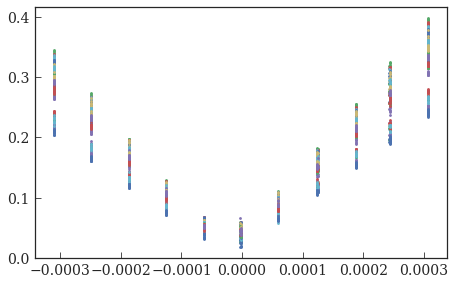

In [60]:
# sanity check 
for k in range(34):
# k=5
    plt.plot(myDataFrame['DVT50_kick'],osc_amplitude_angle[:,k],'.')
    x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,10))

[  3.43188357e-01   1.09173701e+00  -2.42148775e+00  -1.85971405e-03]
7.51114016935e-05 / 7.51114016935e-05


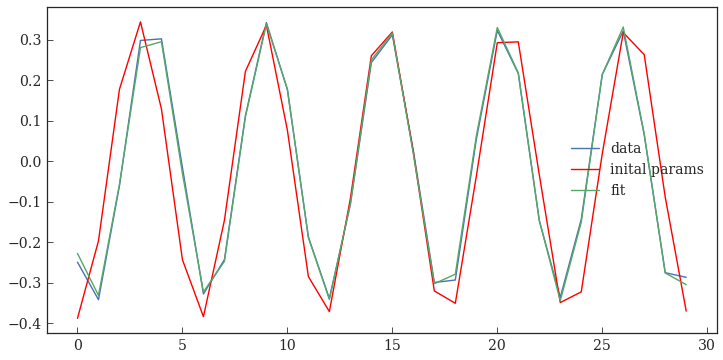

In [61]:
k = 100
m = 25 #bpm number

fig, ax  = plt.subplots(1,figsize=(12,6))
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
ydata = myDataFrame['BPMy_angle'].iloc[k][m,0:30]
ax.plot(ydata,'-',label='data')

p0 = ([1.5*np.std(ydata), 0.33*pi, -pi/2+0*0.03, np.mean(ydata)])
ax.plot(f_to_fit(xdata, *p0), 'r', label='inital params')

bounds=([-np.inf, 0.01*pi, -pi, -np.inf],[np.inf,pi/2.,pi,np.inf])

p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)

yfit = f_to_fit(xdata, *p)

ax.plot(yfit, label='fit')

ax.legend()

print(p)

print(str(chi2[k,m]) + ' / ' + str(np.sum((yfit - ydata)**2)/len(yfit)))

Beta_x at PR.BPM60: 12.27443377


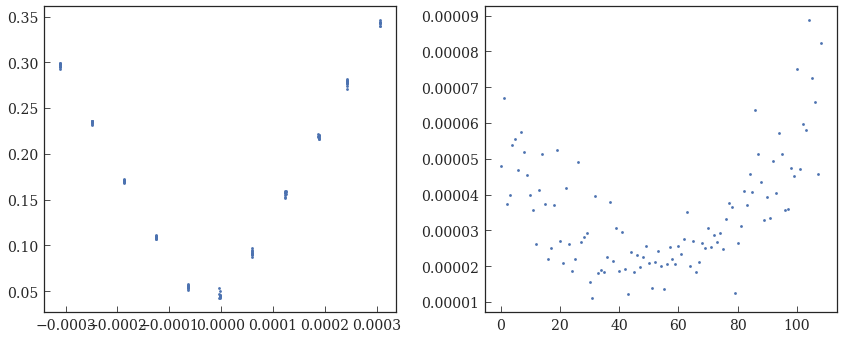

In [62]:
# manual inspection
bpm_n = 25
fig, ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(myDataFrame['DVT50_kick'],osc_amplitude_angle[:,bpm_n],'.')
print 'Beta_x at '+BPM_name[bpm_n]+': '+str(BPM_betax[bpm_n])

ax[1].plot(chi2[:,bpm_n],'.')

fig.tight_layout()

-0.00380386665266
0.346280751696


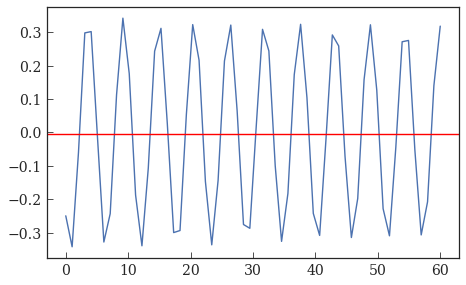

In [63]:
# another manual inspection
mySlice = chi2[:,bpm_n]
ll = np.where(mySlice>.3)
# print chi2[ll,bpm_n]

xdata = np.linspace(0,60,60)
ydata = myDataFrame['BPMy_angle'].iloc[k][m,0:60]

plt.plot(xdata, ydata,'-',label='data') #factors are to adjust units in the plot

print(np.mean(ydata))
plt.axhline(y=np.mean(ydata),color='r')
print(np.max(np.abs(ydata-np.mean(ydata))))

Text(0,0.5,u'Shot number')

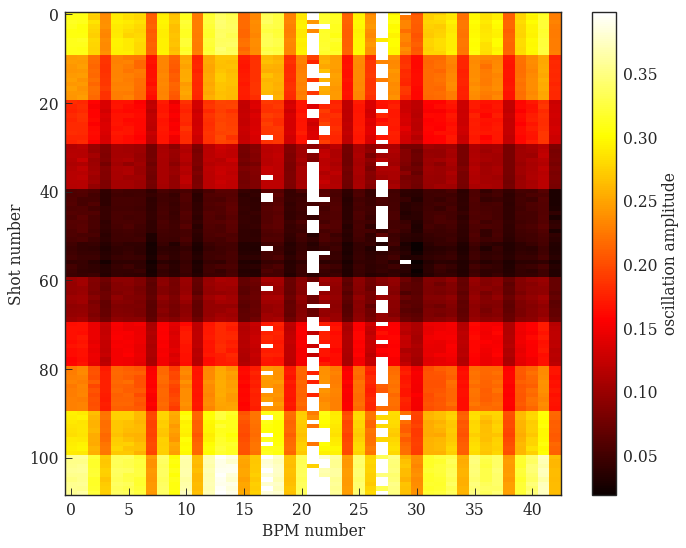

In [64]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(osc_amplitude_angle[:,:],
           cmap='hot',
           aspect='auto'
          )
plt.colorbar(label='oscillation amplitude')
plt.xlabel('BPM number')
plt.ylabel('Shot number')

## 2. RMS orbit deviation 1st-2nd turn and 1st turn-1ms orbit

### calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [65]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
# # bad BPM
# mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
# mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))

# myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaX_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitX_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
#bad BPM
mySeries1 = mySeries1.apply(lambda x: np.delete(x,36))
mySeries2 = mySeries2.apply(lambda x: np.delete(x,36))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaY_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
# myDataFrame['OrbitY_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

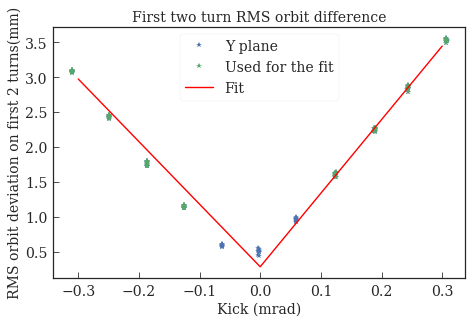

In [75]:
# # # data ONLY
# plt.plot(1e3*myDataFrame['DVT50_kick'],myDataFrame['deltaY_2turns'].values,'*',label='Y plane')

# plt.xlabel('Kick (mrad)')
# plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
# plt.title('First two turn RMS orbit difference')

# # plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaY_2turns'].values,'*',label='Y plane')



# plt.legend(frameon=True)
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')


# Comparison data + MADx 
kick_params = np.load('/eos/user/e/esenes/PS-injection-steering/MADx/6.21-6.185_kick_to_angle_params.npy')
xkick = np.array([ -0.3, 0., 0.3])
# plt.plot(xkick, off + kick_params[1] + np.abs(kick_params[0]*xkick),label='MADx')

plt.plot(1e3*myDataFrame['DVT50_kick'],myDataFrame['deltaY_2turns'].values,'*',label='Y plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference')

# fit the data
def fitF(x,m,q,b):
    return m*np.abs(x-b) + q

bounds=([0.,-np.inf,-0.5],[np.inf,np.inf,0.5])
p0 = [2.,0., -0.1,]
xdata = myDataFrame['DVT50_kick'].loc[myDataFrame['deltaY_2turns']>1.]
ydata = myDataFrame['deltaY_2turns'].loc[myDataFrame['deltaY_2turns']>1.]
plt.plot(1e3*xdata,ydata,'*',label='Used for the fit')


popt, pcov = curve_fit(fitF, 1e3*xdata, ydata,
                      bounds=bounds,p0=p0)
plt.plot(xkick, fitF(xkick, *popt), 'r',label='Fit')





plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

In [76]:
kick_params

array([  9.49073287e+00,   1.88685867e-05])

In [77]:
popt

array([ 10.5427924 ,   0.04749792,  -0.02235324])

Text(0,0.5,u'emiy_geom')

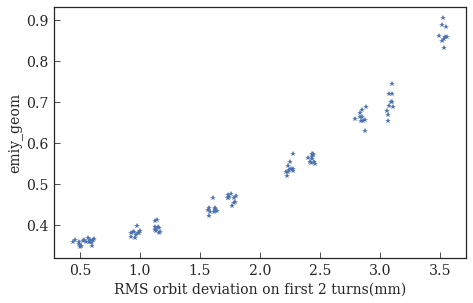

In [78]:
plt.plot(myDataFrame['deltaY_2turns'], myDataFrame['WS_geom_emittance_y'],'*',label='X plane')
plt.xlabel('RMS orbit deviation on first 2 turns(mm)')
plt.ylabel('emiy_geom')


# Methods comparison

## 0) Full formula with angle

In [308]:
bpm_n1 = 2
osc1 = osc_amplitude[:,bpm_n1]
ang1 = osc_amplitude_angle[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betay='+str(BPM_betay[bpm_n1])+' alphay='+str(BPM_alphay[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphay[bpm_n1]**2)/(2*BPM_betay[bpm_n1]))
bpm_n2 = 0
osc2 = osc_amplitude[:,bpm_n2]
ang2 = osc_amplitude_angle[:,bpm_n2]
print 'At '+BPM_name[bpm_n2]+' betay='+str(BPM_betay[bpm_n2])+' alphay='+str(BPM_alphay[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphay[bpm_n2]**2)/(2*BPM_betay[bpm_n2]))

At PR.BPM05 betay=12.17418754 alphay=0.08279305758
Expected value for the fit a=0.0413520280953
At PR.BPM00 betay=22.40821443 alphay=0.1913693271
Expected value for the fit a=0.0231304065434


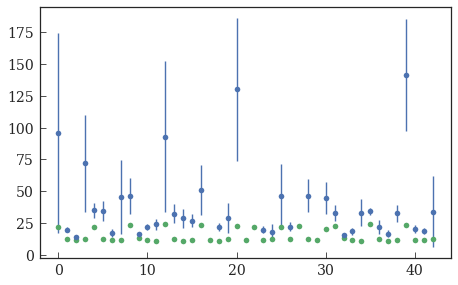

In [345]:
from scipy.optimize import curve_fit

def f_to_fit(X, epsn_0, beta, alpha):
    x1 = X[0]
    x2 = X[1]
    return epsn_0 + (0.5/beta)*(x1**2 + (alpha*x1 + beta*x2)**2)

param_a = np.empty(0,dtype=float)
param_b = np.empty(0,dtype=float)
param_c = np.empty(0,dtype=float)
err_a = np.empty(0,dtype=float)
err_b = np.empty(0,dtype=float)
err_c = np.empty(0,dtype=float)

for bpm_n1 in range(43):

    try:
        osc1 = osc_amplitude[:,bpm_n1]
        ang1 = osc_amplitude_angle[:,bpm_n1]

        x1 = osc1*1e-3
        x2 = ang1*1e-3
        xdata = np.array([x1,x2]) #combined input
        ydata = 1e-6*myDataFrame['WS_geom_emittance_y'].values

        p, cov = curve_fit(f_to_fit,xdata,ydata, maxfev=int(1e5) )
        err = np.sqrt(np.diag(cov))

        param_a = np.append(param_a, p[0])
        param_b = np.append(param_b, p[1])
        param_c = np.append(param_c, p[2])
        err_a = np.append(err_a, err[0])
        err_b = np.append(err_b, err[1])
        err_c = np.append(err_c, err[2])
    except:
        param_a = np.append(param_a, np.nan)
        param_b = np.append(param_b, np.nan)
        param_c = np.append(param_c, np.nan)
        err_a = np.append(err_a, err[0])
        err_b = np.append(err_b, err[1])
        err_c = np.append(err_c, err[2])



# fig, ax = plt.subplots(1,2,figsize=(10,10))
xx = np.linspace(0, 42, 43)
plt.errorbar(xx, param_b, yerr=err_b ,label='beta fit', fmt='o')
plt.plot(BPM_betay,'o',label='model')



## 1) Single BPM method

In [310]:
bpm_n1 = 2
osc1 = osc_amplitude[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betay='+str(BPM_betay[bpm_n1])+' alphay='+str(BPM_alphay[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphay[bpm_n1]**2)/(2*BPM_betay[bpm_n1]))
bpm_n2 = 0
osc2 = osc_amplitude[:,bpm_n2]
print 'At '+BPM_name[bpm_n2]+' betay='+str(BPM_betay[bpm_n2])+' alphay='+str(BPM_alphay[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphay[bpm_n2]**2)/(2*BPM_betay[bpm_n2]))

At PR.BPM05 betay=12.17418754 alphay=0.08279305758
Expected value for the fit a=0.0413520280953
At PR.BPM00 betay=22.40821443 alphay=0.1913693271
Expected value for the fit a=0.0231304065434


Model function: a(x)^2 + c
Fit params: a=0.0357369522568+/-0.000345159797277
 c= 3.46608013849e-07+/-2.21606275917e-09
 
At PR.BPM05 betay=12.17418754 alphay=0.08279305758
Expected value for the fit a=0.0413520280953


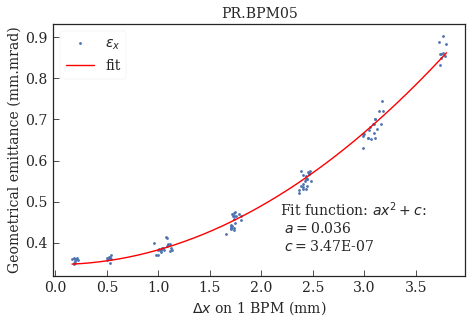

In [311]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x )**2 + c

xdata = 1e-3*osc1
ydata = 1e-6*myDataFrame['WS_geom_emittance_y']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)
err = np.sqrt(np.diag(cov))

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + '+/-' + str(err[0]) + '\n c= '+ str(p[1]) + '+/-' + str(err[1])



plt.xlabel('$\Delta x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n1])

ax.text(0.55, 0.3, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n1]+' betay='+str(BPM_betay[bpm_n1])+' alphay='+str(BPM_alphay[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphay[bpm_n1]**2)/(2*BPM_betay[bpm_n1]))


plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,2.5))

fig.savefig('single_BPM185.eps', format='eps')

Model function: a(x)^2 + c
Fit params: a=0.0137668396758+/-0.000151918601631
 c= 3.38948977388e-07+/-2.59366450529e-09
 
At PR.BPM00 betay=22.40821443 alphay=0.1913693271
Expected value for the fit a=0.0231304065434


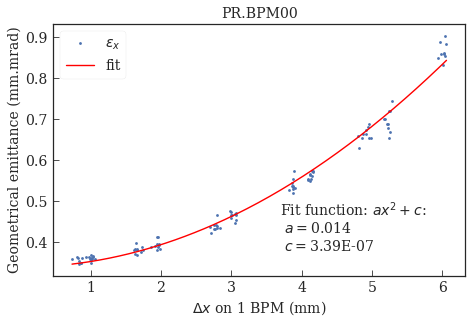

In [312]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x )**2 + c

xdata = 1e-3*osc2
ydata = 1e-6*myDataFrame['WS_geom_emittance_y']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)
err = np.sqrt(np.diag(cov))

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: a=' + str(p[0]) + '+/-' + str(err[0]) + '\n c= '+ str(p[1]) + '+/-' + str(err[1])



plt.xlabel('$\Delta x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n2])

ax.text(0.55, 0.3, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n2]+' betay='+str(BPM_betay[bpm_n2])+' alphay='+str(BPM_alphay[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphay[bpm_n2]**2)/(2*BPM_betay[bpm_n2]))


plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,2.5))

fig.savefig('single_BPM185.eps', format='eps')

At PR.BPM05 betax=21.46655428 alphax=0.06064786375
Expected value for the fit a=0.0233777193649
At PR.BPM00 betax=22.40821443 alphax=0.1913693271
Expected value for the fit a=0.0231304065434
Fit params: a=0.0137668396758+/-0.000151918601631
 c= 3.38948977388e-07+/-2.59366450529e-09
 
At PR.BPM03 betax=12.33988344 alphax=0.019034109
Expected value for the fit a=0.0405337012367
Fit params: a=0.0309128657878+/-0.000379708581937
 c= 3.44601118823e-07+/-2.83286257026e-09
 
At PR.BPM05 betax=12.17418754 alphax=0.08279305758
Expected value for the fit a=0.0413520280953
Fit params: a=0.0357369522568+/-0.000345159797277
 c= 3.46608013849e-07+/-2.21606275917e-09
 
At PR.BPM07 betax=12.27703006 alphax=-0.08469116242
Expected value for the fit a=0.0410185764827
Fit params: a=0.0245489587269+/-0.00027370623779
 c= 3.42588289969e-07+/-2.58977630107e-09
 
At PR.BPM10 betax=22.28025192 alphax=0.1733935533
Expected value for the fit a=0.0231161058687
Fit params: a=0.0164806228113+/-0.000184714713976
 c

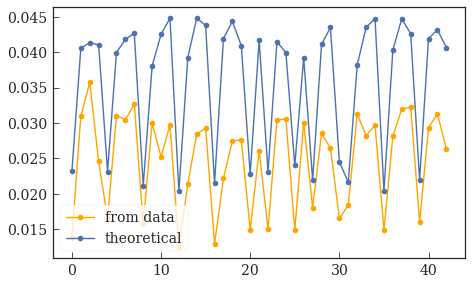

In [313]:
# look at all the BPMS
osc1 = osc_amplitude[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))

def f_to_fit(x, a, c):
    return a*(x )**2 + c



param_a = np.empty(0,dtype=float)
param_c = np.empty(0,dtype=float)
expected_a = np.empty(0,dtype=float)


for bpm_n1 in range(43):
    
    osc1 = osc_amplitude[:,bpm_n1]
    print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betay[bpm_n1])+' alphax='+str(BPM_alphay[bpm_n1])
    print 'Expected value for the fit a='+str((1+BPM_alphay[bpm_n1]**2)/(2*BPM_betay[bpm_n1]))

    xdata = 1e-3*osc1
    ydata = 1e-6*myDataFrame['WS_geom_emittance_y']

    p, cov = curve_fit(f_to_fit,xdata,ydata)
    err = np.sqrt(np.diag(cov))

    xfit = np.linspace(np.min(xdata),np.max(xdata),200)
    ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot
    print 'Fit params: a=' + str(p[0]) + '+/-' + str(err[0]) + '\n c= '+ str(p[1]) + '+/-' + str(err[1])

    param_a = np.append(param_a, p[0])
    param_c = np.append(param_c, p[1])
    expected_a = np.append(expected_a, ((1+BPM_alphay[bpm_n1]**2)/(2*BPM_betay[bpm_n1])) )
    
    
    print ' '


plt.plot(param_a,'o-',color='orange',label='from data')
plt.plot(expected_a,'o-',label='theoretical')
plt.legend(frameon=True)

## 2) All BPM - single turn method

### Expectation value

In [315]:
exp_a_allBPM = np.mean((1 + (BPM_alphay**2))/(2*BPM_betay))

### Measurements result

Model function: a(x)^2 + c
Fit params: 
 a= 0.0398609425058+/-0.000456327764668
 c= 3.40249139139e-07+/-2.67888620996e-09
 
Expected value for the fit a=0.0358955820268


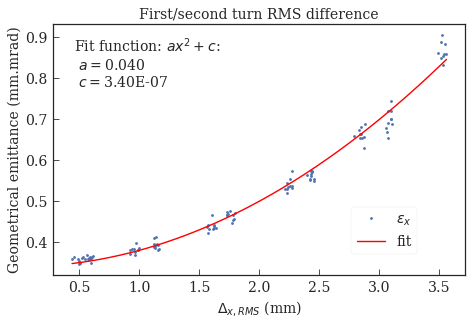

In [317]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x)**2 + c

xdata = 1e-3*myDataFrame['deltaY_2turns']
ydata = 1e-6*myDataFrame['WS_geom_emittance_y']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)
err = np.sqrt(np.diag(cov))

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x)^2 + c'
print 'Fit params: \n a= ' + str(p[0]) + '+/-' + str(err[0]) + '\n c= '+ str(p[1]) + '+/-' + str(err[1])


plt.xlabel('$\Delta_{x,RMS}$ (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title('First/second turn RMS difference')

ax.text(0.05, 0.95, 'Fit function: $ax^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True, bbox_to_anchor=(0.9,0.3))
print ' '
print 'Expected value for the fit a='+str(exp_a_allBPM)



x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1,1.9))

fig.savefig('all_BPM185.eps', format='eps')

# Laslett tune shift calculation

In [318]:
myDataFrame['peakLineDensity'] = 0.58

In [319]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [320]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

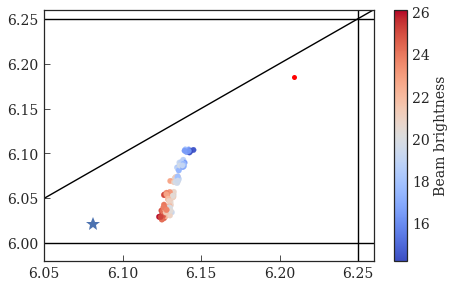

In [321]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.209
Qy = 6.185
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.05, 6.26])
plt.ylim([5.98, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

# PSB point
[deltaQxPSB, deltaQyPSB] = laslett_sc_PS(0.58, 0.893e-3,
              1e-6*0.777, 1e-6*0.959,
              1400, twiss_file_name)
plt.plot(Qx+deltaQxPSB,Qy+deltaQyPSB,'*',markersize=15)


plt.show()

fig.savefig('BCMS_under_coupling_footprint.eps', format='eps')